<a href="https://colab.research.google.com/github/phanee16/Car_price_Prediction_Pyspark_ML/blob/main/car_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install the libraries and load the data


In [4]:
# # Install pyspark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 15.6 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=a8f58511ef6df9e7081e24acb47eb2636c3b6899a57e28cf7794bd92f43b890f
  Stored in directory: /root/.cache/pip/wheels/b1/59/a0/a1a0624b5e865fd389919c1a10f53aec9b12195d6747710baf
Successfully built pyspark


In [5]:
# Import all the required libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import isnan, when, count, col, lit
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder


In [6]:
# Create a spark session
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [7]:
# check it
spark

In [8]:
# Upload the data file to google colab
from google.colab import files
files.upload()

Saving data.csv to data.csv


{'data.csv': b'Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP\nBMW,1 Series M,2011,premium unleaded (required),335,6,MANUAL,rear wheel drive,2,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135\nBMW,1 Series,2011,premium unleaded (required),300,6,MANUAL,rear wheel drive,2,"Luxury,Performance",Compact,Convertible,28,19,3916,40650\nBMW,1 Series,2011,premium unleaded (required),300,6,MANUAL,rear wheel drive,2,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350\nBMW,1 Series,2011,premium unleaded (required),230,6,MANUAL,rear wheel drive,2,"Luxury,Performance",Compact,Coupe,28,18,3916,29450\nBMW,1 Series,2011,premium unleaded (required),230,6,MANUAL,rear wheel drive,2,Luxury,Compact,Convertible,28,18,3916,34500\nBMW,1 Series,2012,premium unleaded (required),230,6,MANUAL,rear wheel drive,2,"Luxury,Performance",Compact,Coupe,28,1

In [39]:
data_df = spark.read.csv('data.csv',inferSchema= True,header = True)

In [40]:
data_df.show()

+----+----------+----+--------------------+---------+----------------+-----------------+-----------------+---------------+--------------------+------------+-------------+-----------+--------+----------+-----+
|Make|     Model|Year|    Engine Fuel Type|Engine HP|Engine Cylinders|Transmission Type|    Driven_Wheels|Number of Doors|     Market Category|Vehicle Size|Vehicle Style|highway MPG|city mpg|Popularity| MSRP|
+----+----------+----+--------------------+---------+----------------+-----------------+-----------------+---------------+--------------------+------------+-------------+-----------+--------+----------+-----+
| BMW|1 Series M|2011|premium unleaded ...|      335|               6|           MANUAL| rear wheel drive|              2|Factory Tuner,Lux...|     Compact|        Coupe|         26|      19|      3916|46135|
| BMW|  1 Series|2011|premium unleaded ...|      300|               6|           MANUAL| rear wheel drive|              2|  Luxury,Performance|     Compact|  Conver

# Check the schema and statistics of the data


In [41]:
print((data_df.count(),len(data_df.columns)))

(11914, 16)


In [42]:
data_df.printSchema()

root
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Engine Fuel Type: string (nullable = true)
 |-- Engine HP: integer (nullable = true)
 |-- Engine Cylinders: integer (nullable = true)
 |-- Transmission Type: string (nullable = true)
 |-- Driven_Wheels: string (nullable = true)
 |-- Number of Doors: integer (nullable = true)
 |-- Market Category: string (nullable = true)
 |-- Vehicle Size: string (nullable = true)
 |-- Vehicle Style: string (nullable = true)
 |-- highway MPG: integer (nullable = true)
 |-- city mpg: integer (nullable = true)
 |-- Popularity: integer (nullable = true)
 |-- MSRP: integer (nullable = true)



In [43]:
data_df.describe().toPandas().transpose()

0                   1                   2  \
summary            count                mean              stddev   
Make               11914                None                None   
Model              11914   745.5822222222222  1490.8280590623795   
Year               11914   2010.384337753903  7.5797398875957995   
Engine Fuel Type   11911                None                None   
Engine HP          11845  249.38607007176023  109.19187025917194   
Engine Cylinders   11884   5.628828677213059    1.78055934824622   
Transmission Type  11914                None                None   
Driven_Wheels      11914                None                None   
Number of Doors    11908  3.4360933825999327  0.8813153865835529   
Market Category    11914                None                None   
Vehicle Size       11914                None                None   
Vehicle Style      11914                None                None   
highway MPG        11914  26.637485311398354   8.863000766979422   
city mpg           11914   19.73325499412456   8.987798160299237   
Popularity         11914  1554.9111969111968  1441.8553466274648   
MSRP               11914  40594.737032063116   60109.10360365422   

                                  3                   4  
summary                         min                 max  
Make                          Acura               Volvo  
Model                      1 Series                  xD  
Year                           1990                2017  
Engine Fuel Type             diesel    regular unleaded  
Engine HP                        55                1001  
Engine Cylinders                  0                  16  
Transmission Type  AUTOMATED_MANUAL             UNKNOWN  
Driven_Wheels       all wheel drive    rear wheel drive  
Number of Doors                   2                   4  
Market Category           Crossover  Performance,Hybrid  
Vehicle Size                Compact             Midsize  
Vehicle Style         2dr Hatchback               Wagon  
highway MPG                      12                 354  
city mpg                          7                 137  
Popularity                        2                5657  
MSRP                           2000             2065902

# Exploratory data analysis and data visualization 

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of the year')

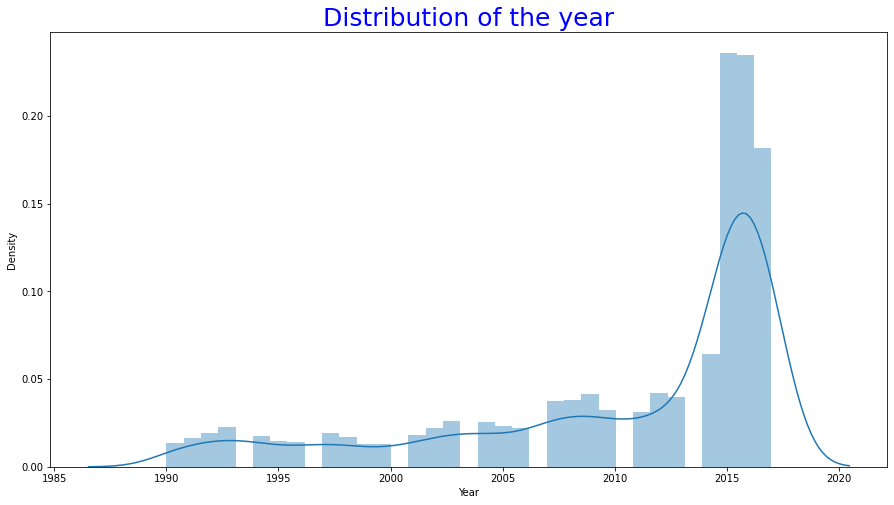

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
sns.distplot(data_df.toPandas()['Year'])
plt.title('Distribution of the year', {"color":"blue", "fontsize":25})

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of the Engine HP')

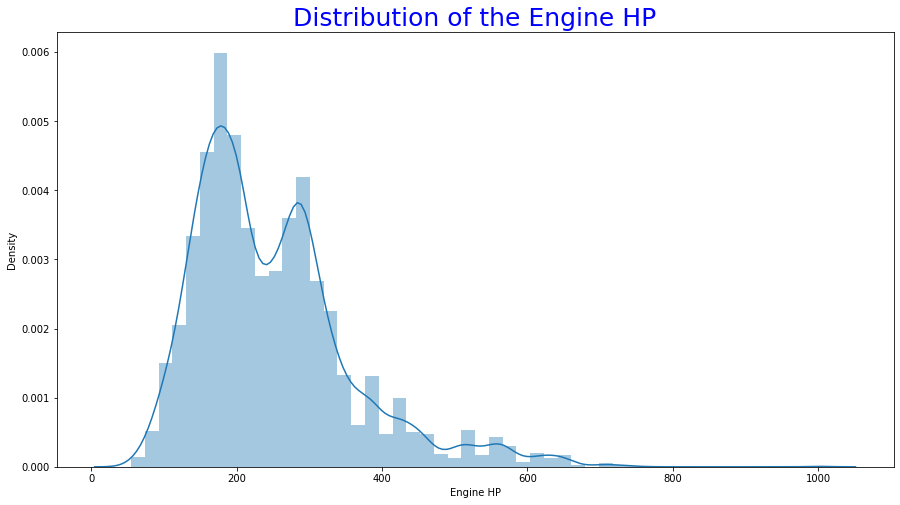

In [47]:
plt.figure(figsize=(15,8))
sns.distplot(data_df.toPandas()['Engine HP'])
plt.title('Distribution of the Engine HP', {"color":"blue", "fontsize":25})

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of the Engine Cylinders')

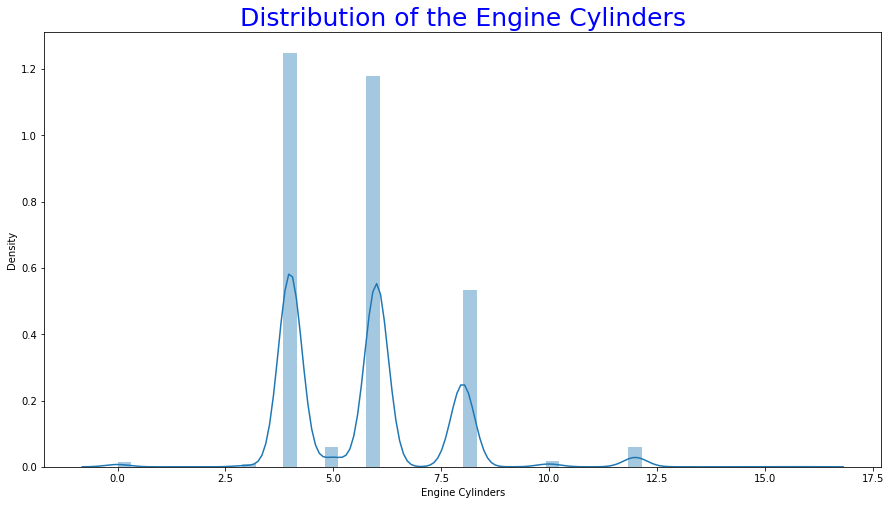

In [48]:
plt.figure(figsize=(15,8))
sns.distplot(data_df.toPandas()['Engine Cylinders'])
plt.title('Distribution of the Engine Cylinders', {"color":"blue", "fontsize":25})

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of the highway MPG')

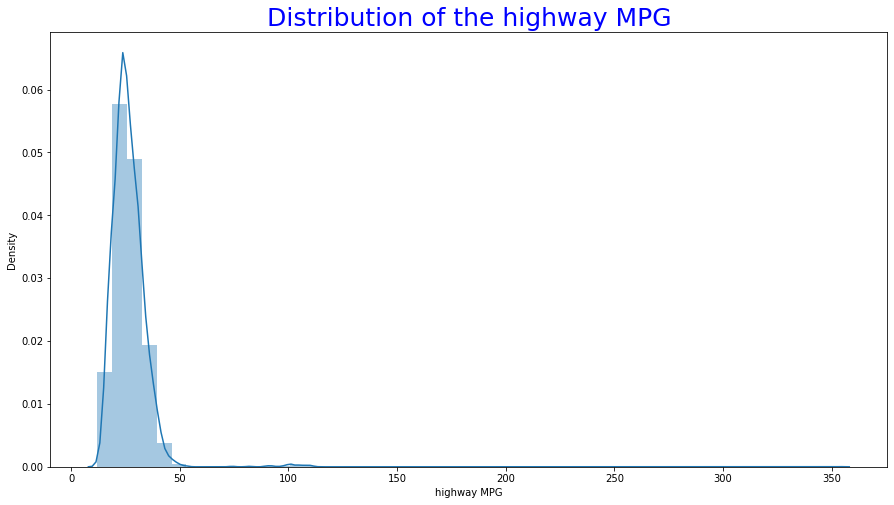

In [50]:
plt.figure(figsize=(15,8))
sns.distplot(data_df.toPandas()['highway MPG'])
plt.title('Distribution of the highway MPG', {"color":"blue", "fontsize":25})

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of the city mpg')

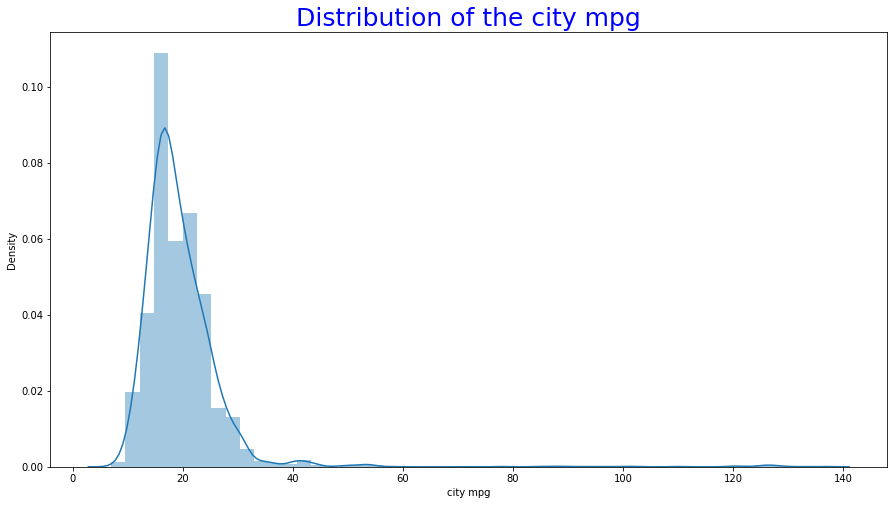

In [51]:
plt.figure(figsize=(15,8))
sns.distplot(data_df.toPandas()['city mpg'])
plt.title('Distribution of the city mpg', {"color":"blue", "fontsize":25})

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of the Popularity')

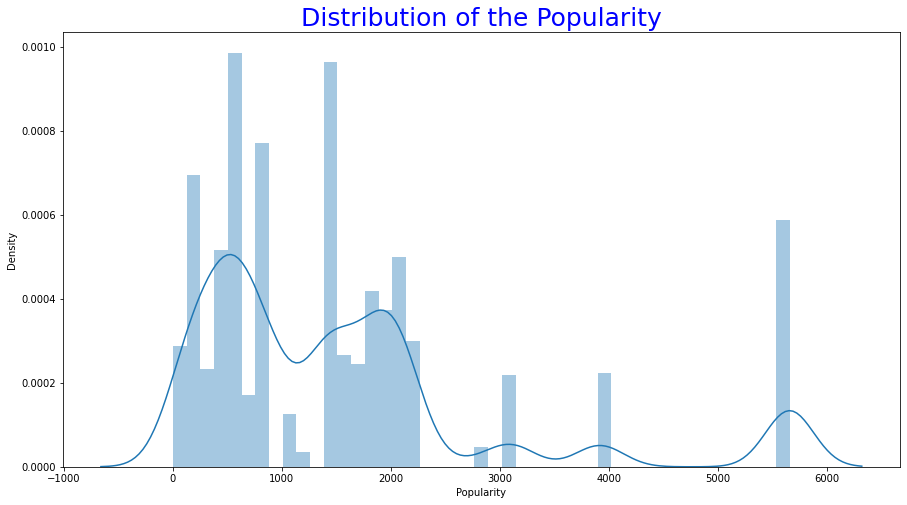

In [52]:
plt.figure(figsize=(15,8))
sns.distplot(data_df.toPandas()['Popularity'])
plt.title('Distribution of the Popularity', {"color":"blue", "fontsize":25})

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of the MSRP')

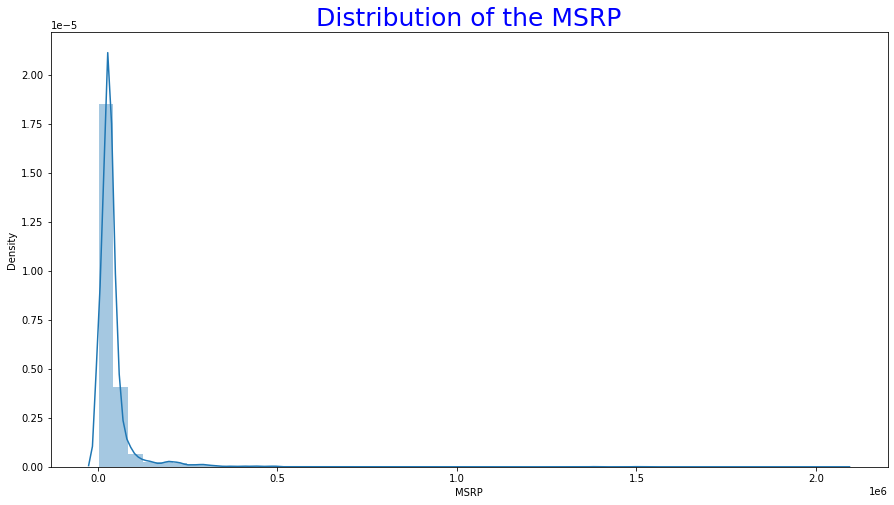

In [53]:
plt.figure(figsize=(15,8))
sns.distplot(data_df.toPandas()['MSRP'])
plt.title('Distribution of the MSRP', {"color":"blue", "fontsize":25})

We can observe that the Manufacturer's Suggested Retail Price is right skewed. But there are some outliers which are basically cars that are personalized according to the order.

Therefore check the distribution on the boxplot.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of the MSRP')

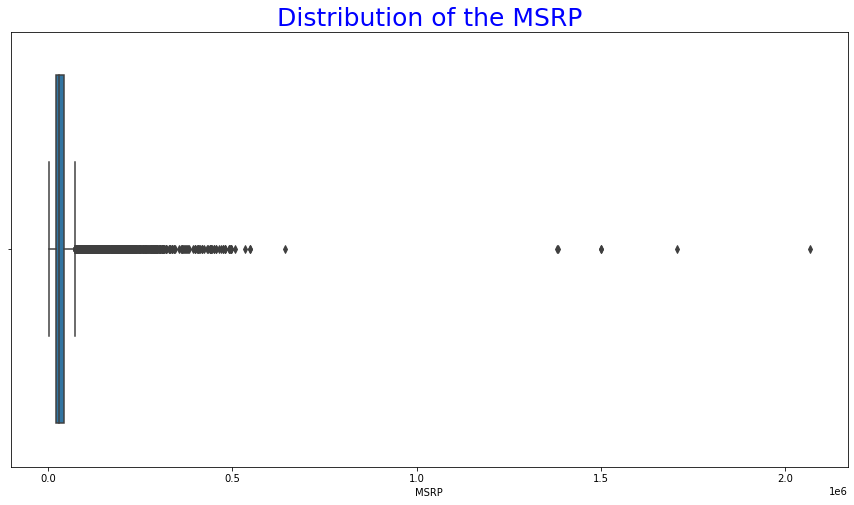

In [54]:
plt.figure(figsize=(15,8))
sns.boxplot(data_df.toPandas()['MSRP'])
plt.title('Distribution of the MSRP', {"color":"blue", "fontsize":25})

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Popularity vs MSRP')

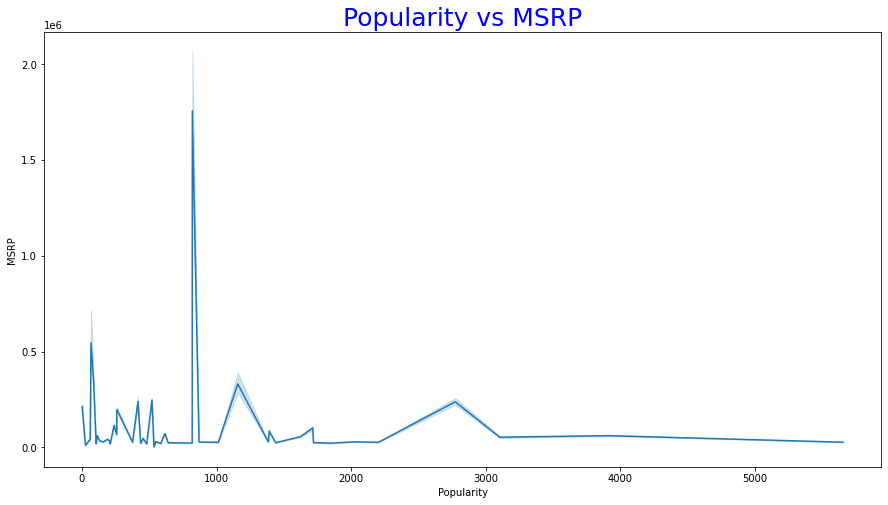

In [58]:

import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
sns.lineplot(data_df.toPandas()['Popularity'],data_df.toPandas()['MSRP'])
plt.title('Popularity vs MSRP', {"color":"blue", "fontsize":25})

# Check the brand-wise city milage of the cars

In [28]:
brand = data_df.toPandas().Make.unique()
brand

array(['BMW', 'Audi', 'FIAT', 'Mercedes-Benz', 'Chrysler', 'Nissan',
       'Volvo', 'Mazda', 'Mitsubishi', 'Ferrari', 'Alfa Romeo', 'Toyota',
       'McLaren', 'Maybach', 'Pontiac', 'Porsche', 'Saab', 'GMC',
       'Hyundai', 'Plymouth', 'Honda', 'Oldsmobile', 'Suzuki', 'Ford',
       'Cadillac', 'Kia', 'Bentley', 'Chevrolet', 'Dodge', 'Lamborghini',
       'Lincoln', 'Subaru', 'Volkswagen', 'Spyker', 'Buick', 'Acura',
       'Rolls-Royce', 'Maserati', 'Lexus', 'Aston Martin', 'Land Rover',
       'Lotus', 'Infiniti', 'Scion', 'Genesis', 'HUMMER', 'Tesla',
       'Bugatti'], dtype=object)

In [29]:
pd_df = data_df.toPandas()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 864x648 with 0 Axes>

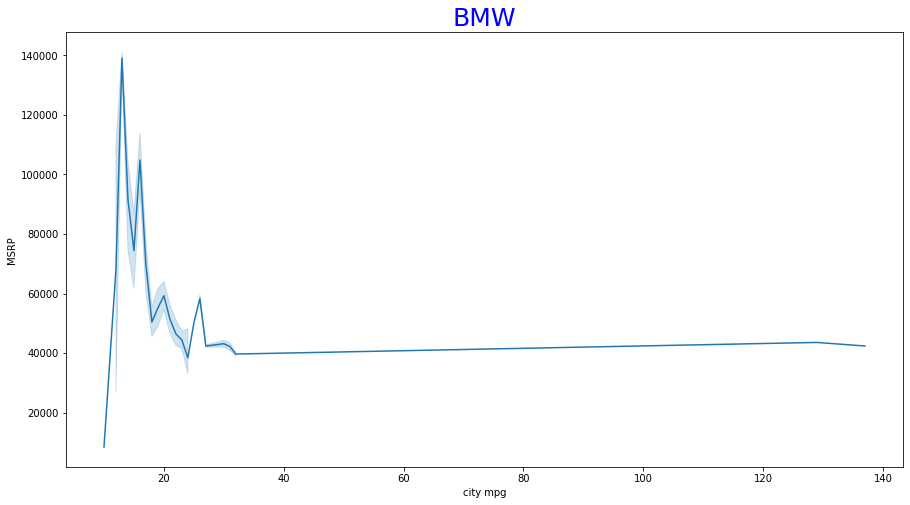

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


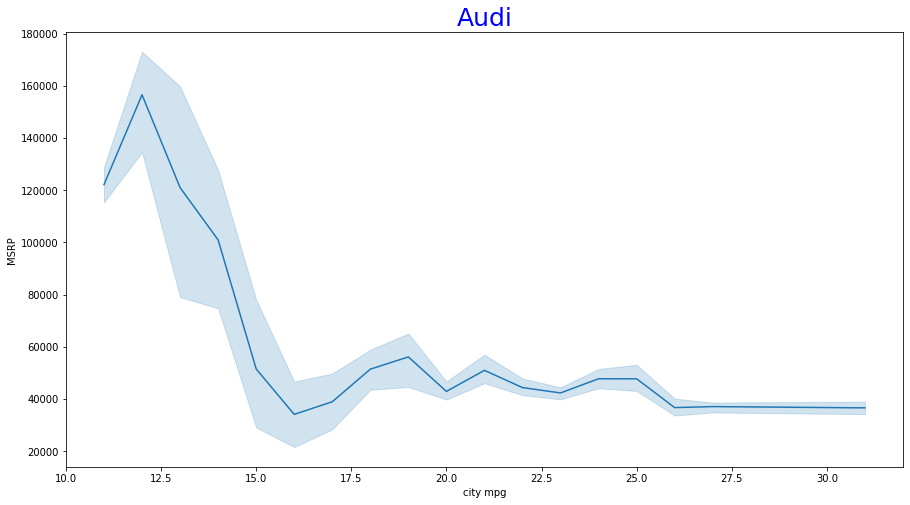

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


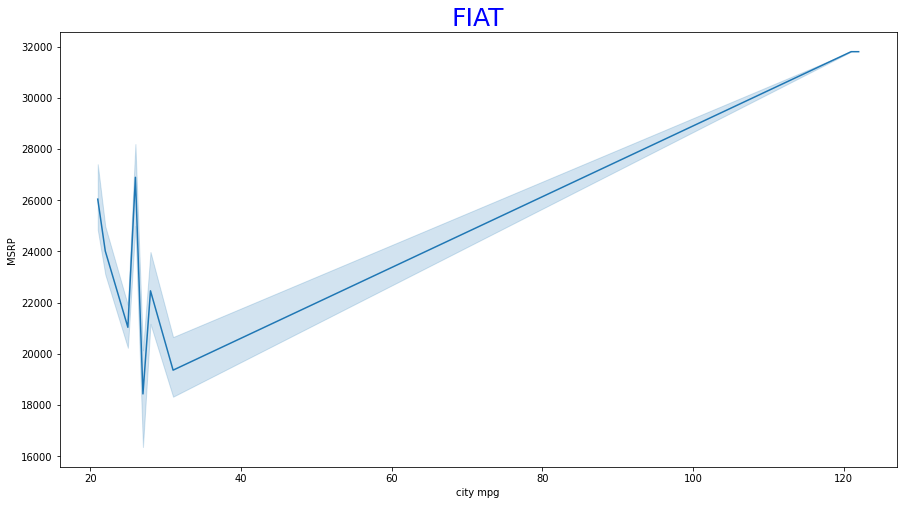

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


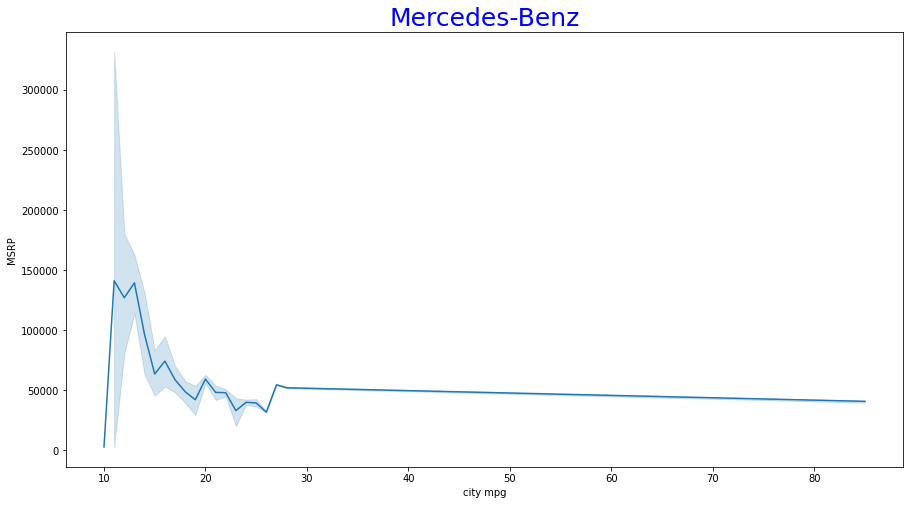

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


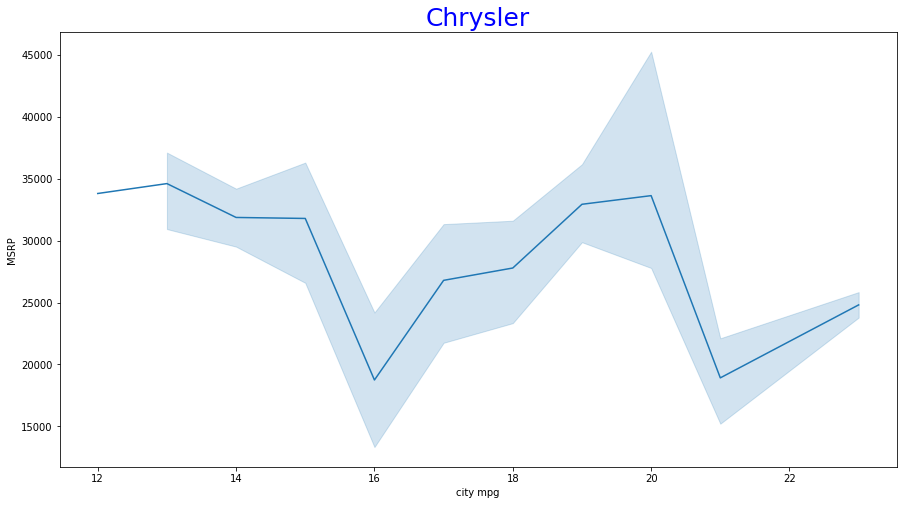

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


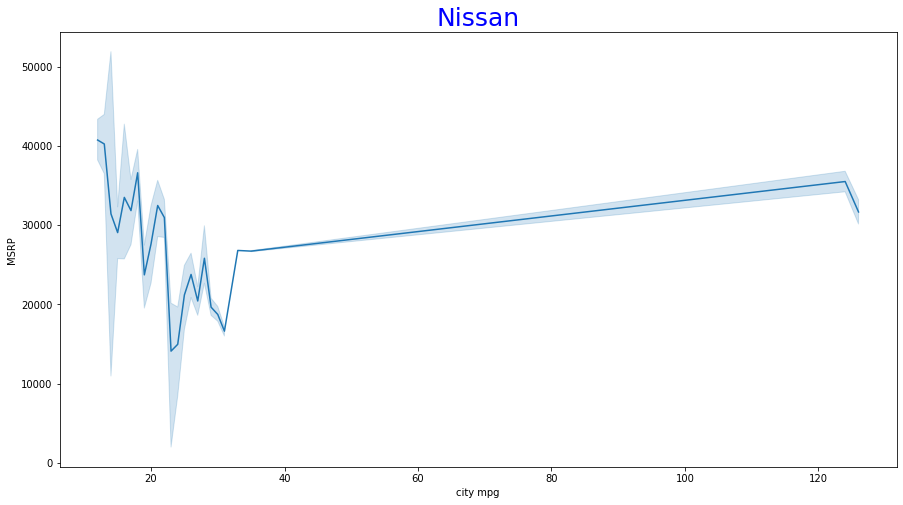

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


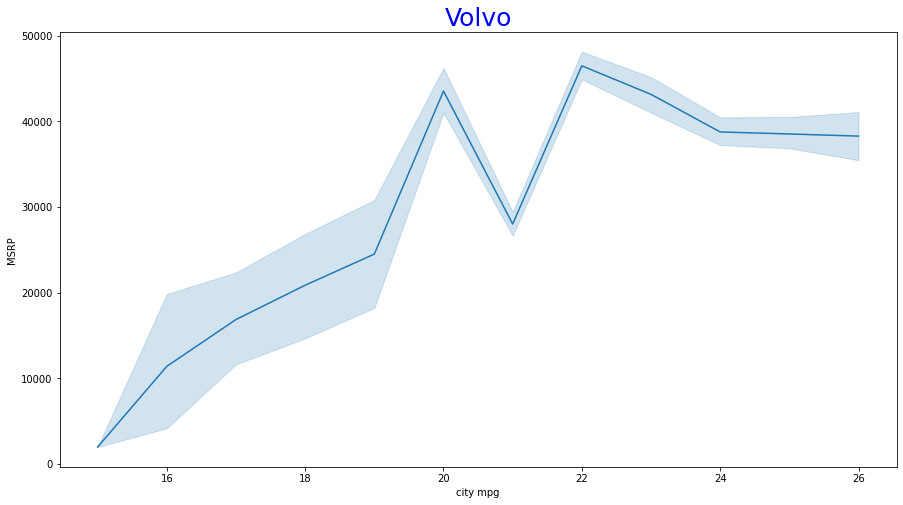

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


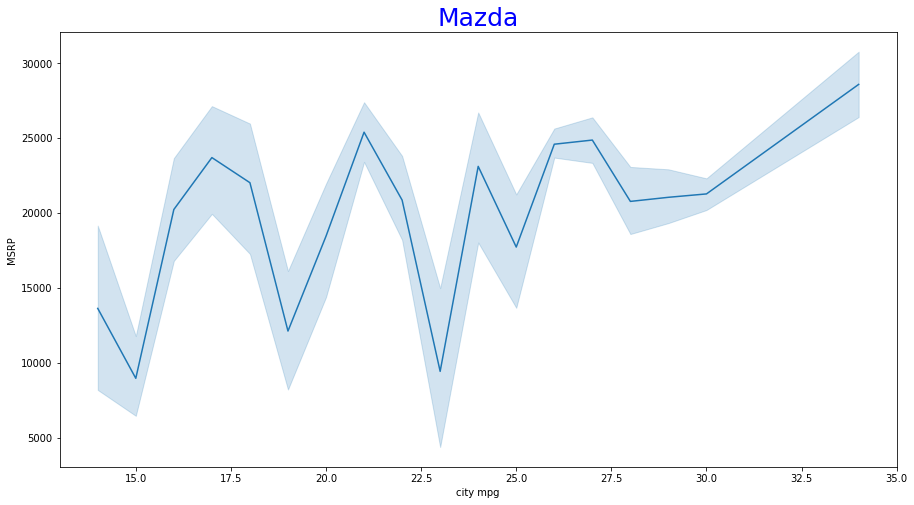

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


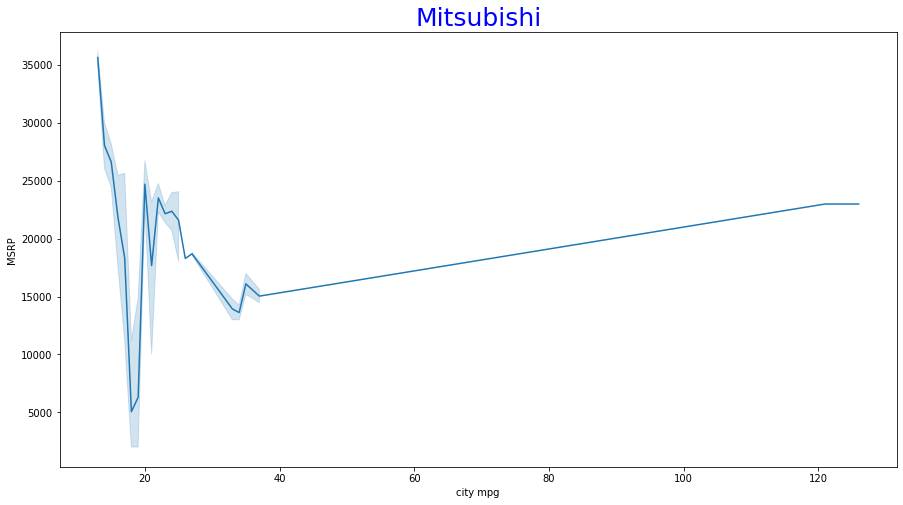

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


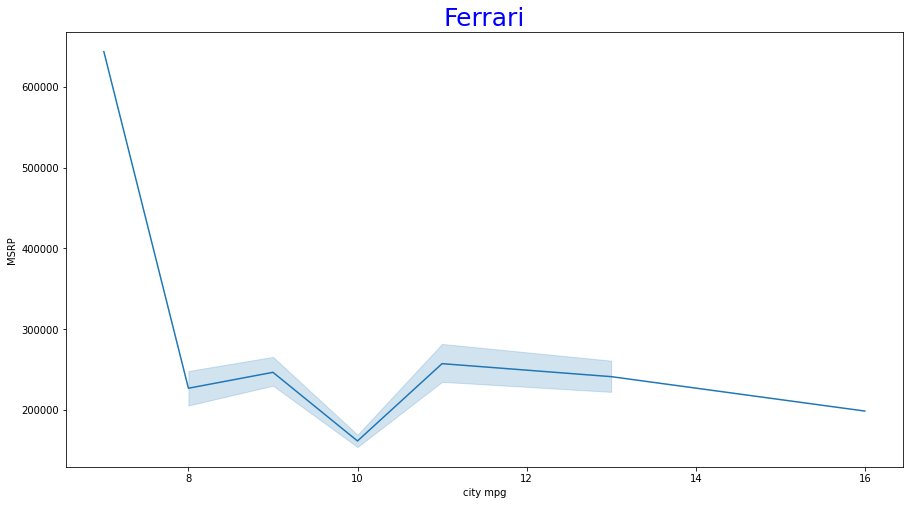

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


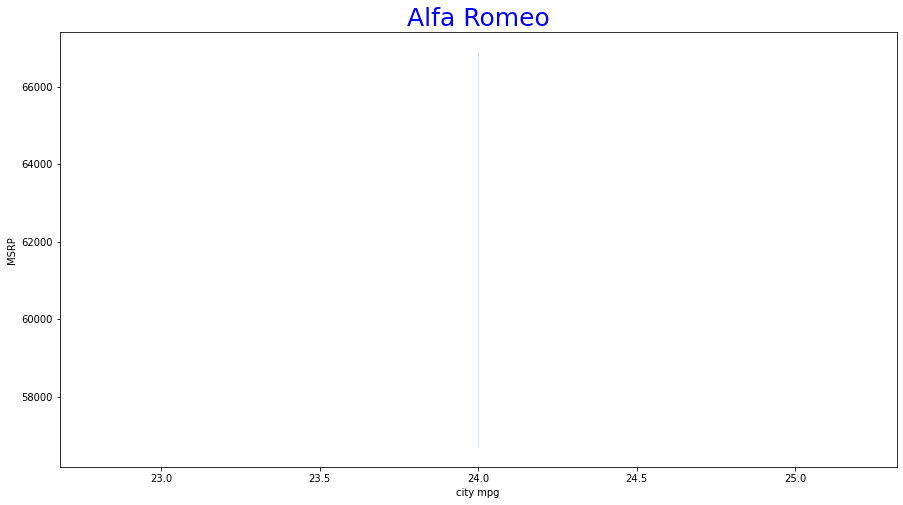

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


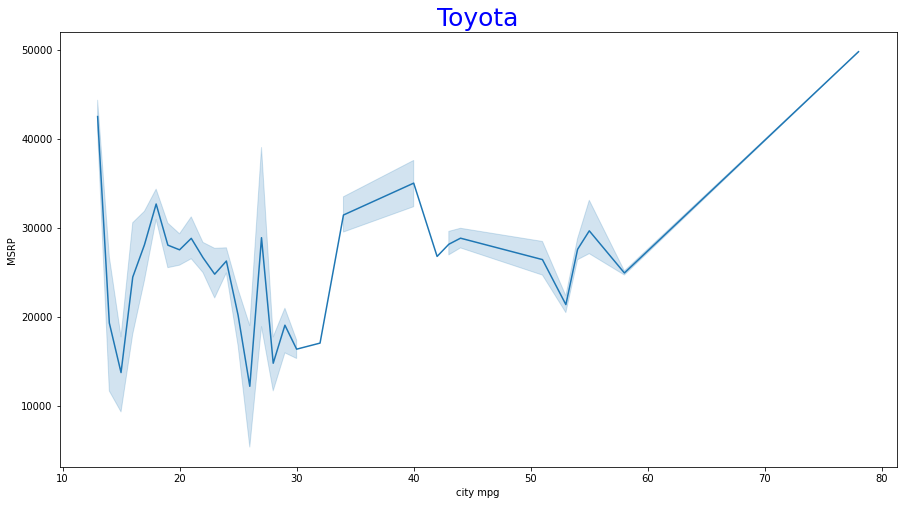

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


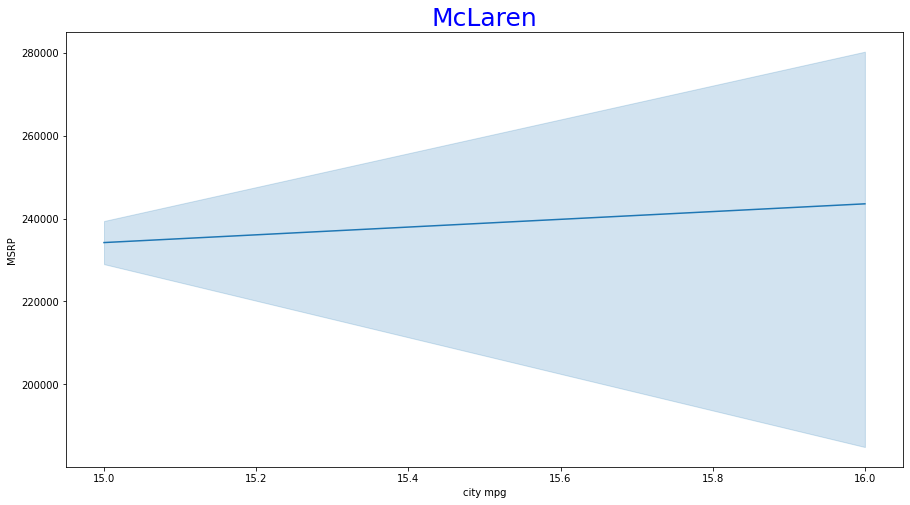

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


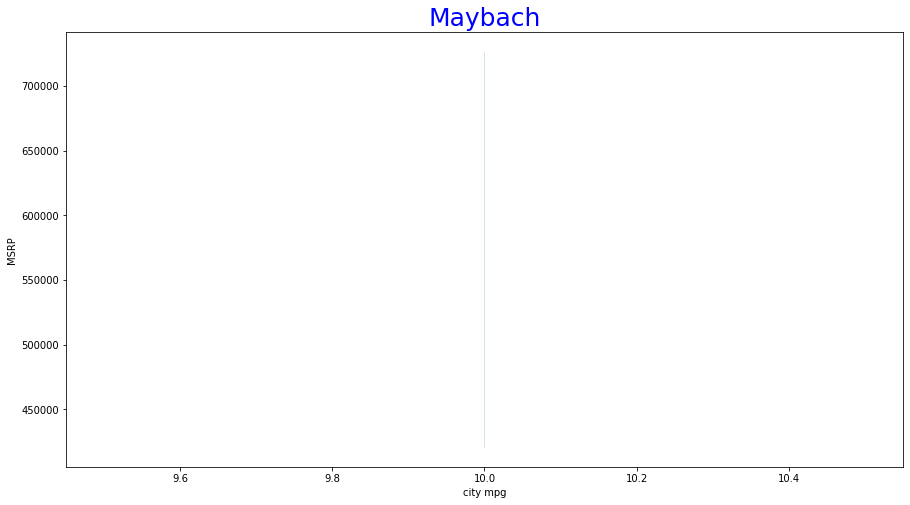

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


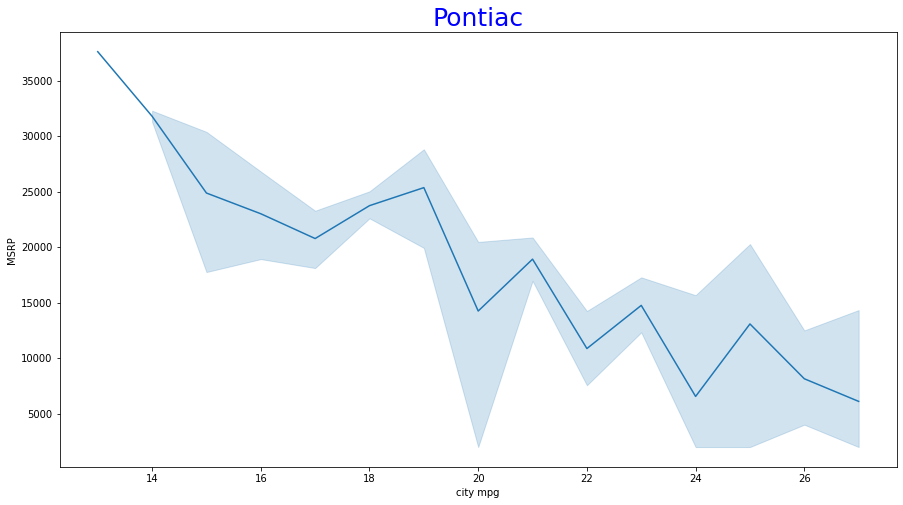

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


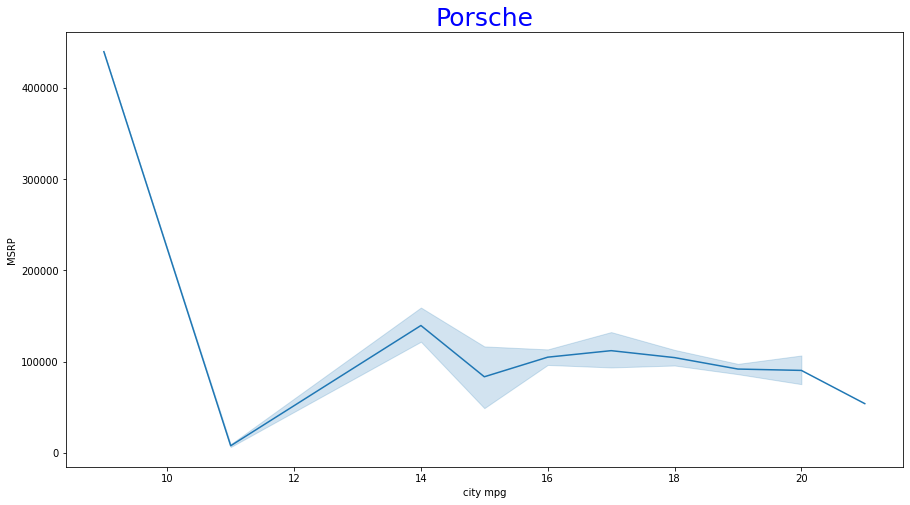

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


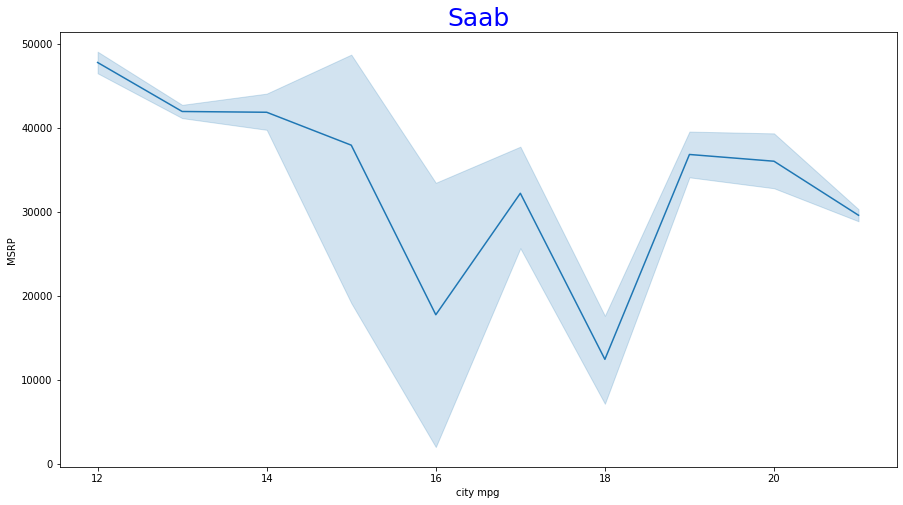

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


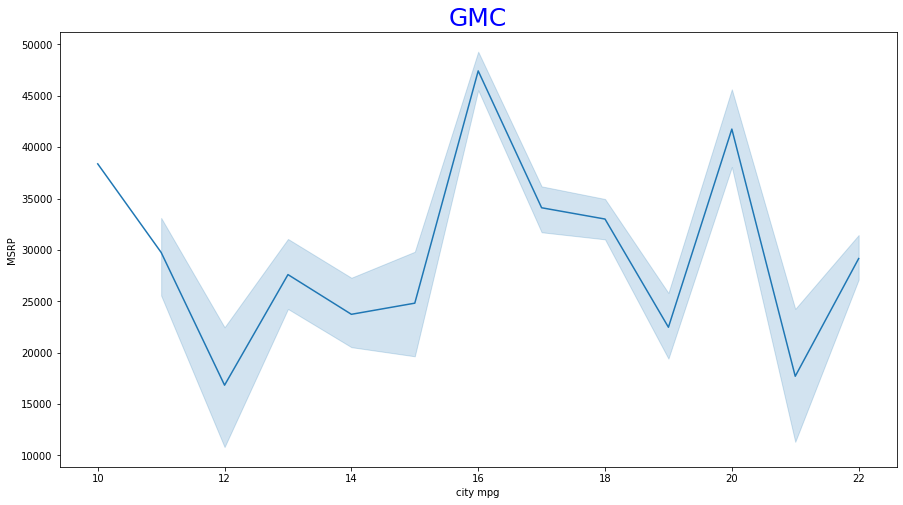

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


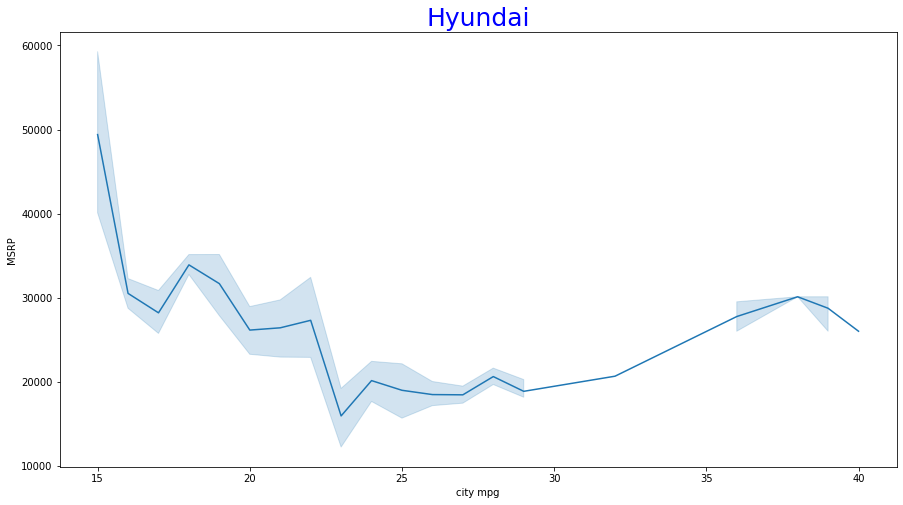

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


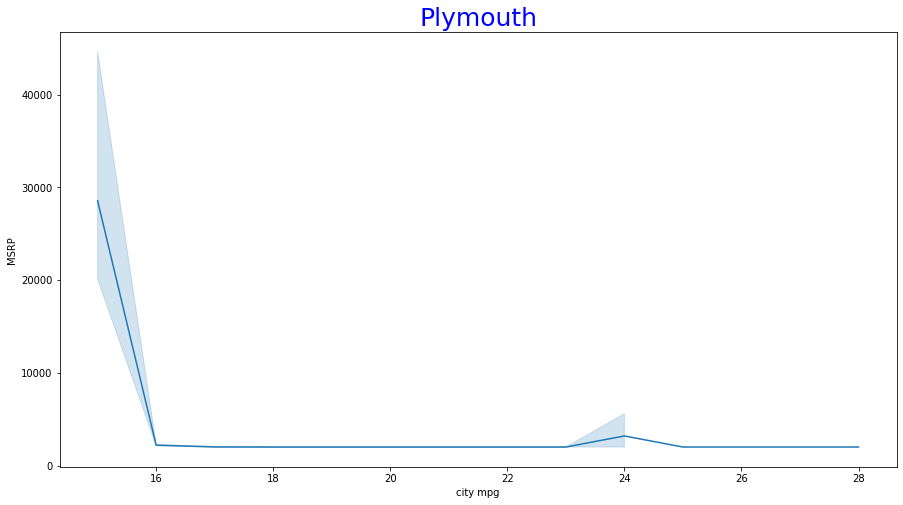

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


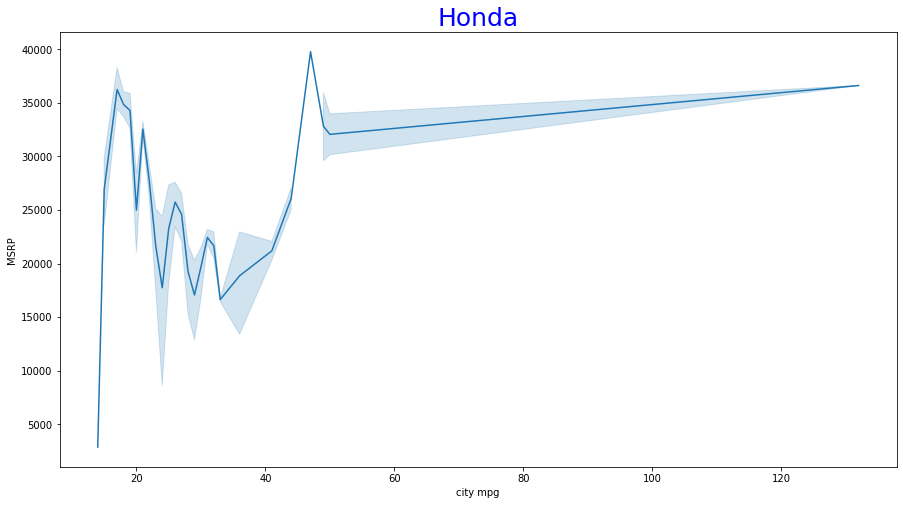

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


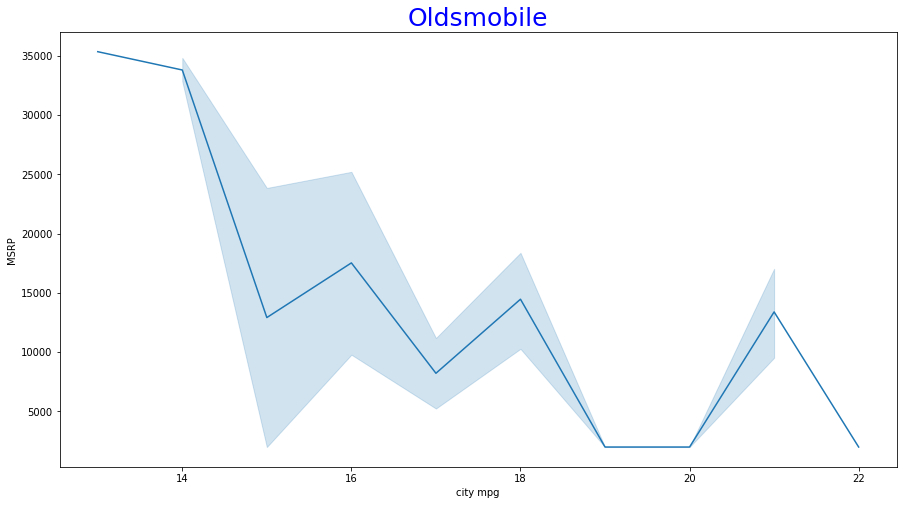

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


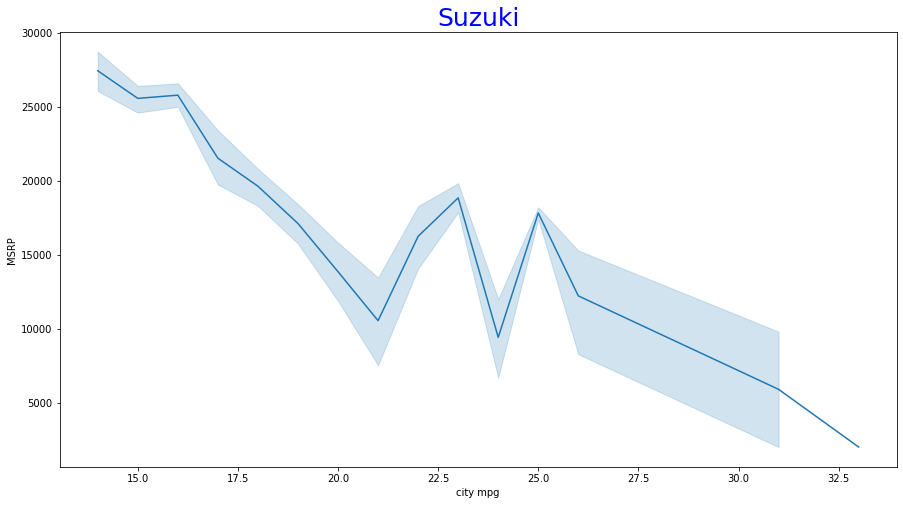

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


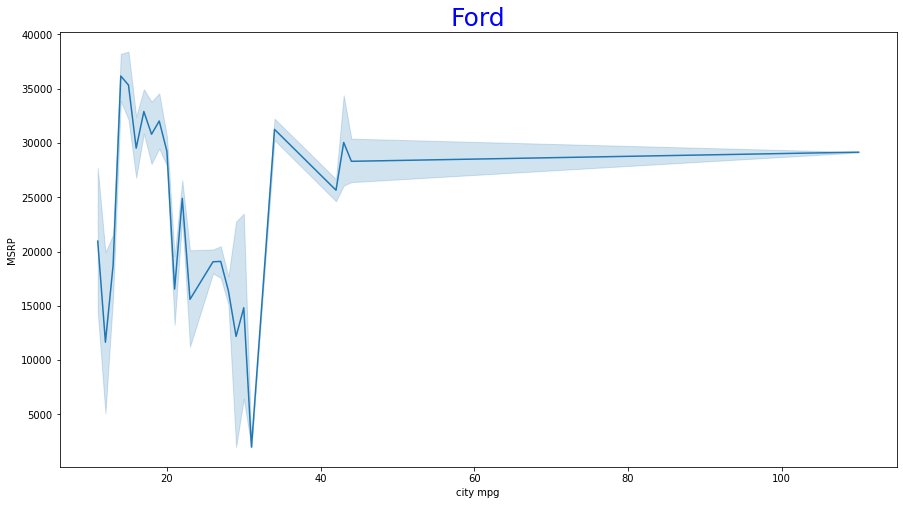

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


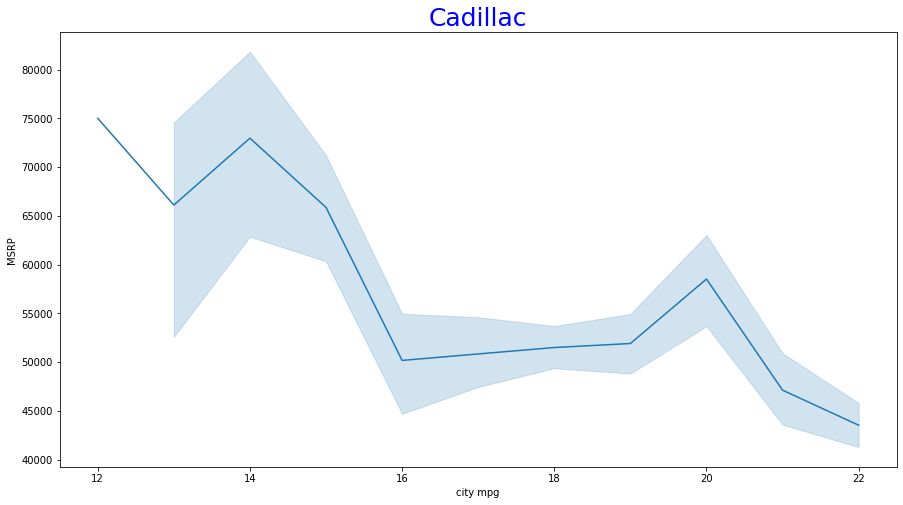

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


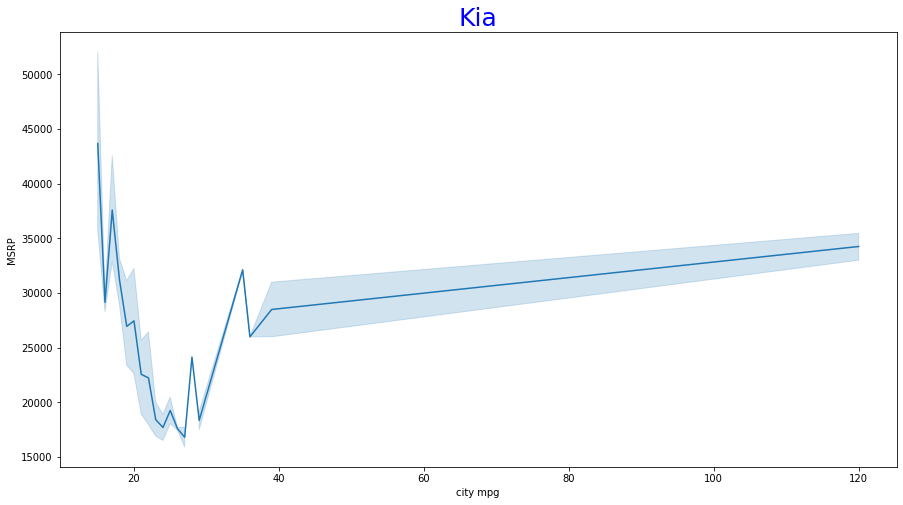

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


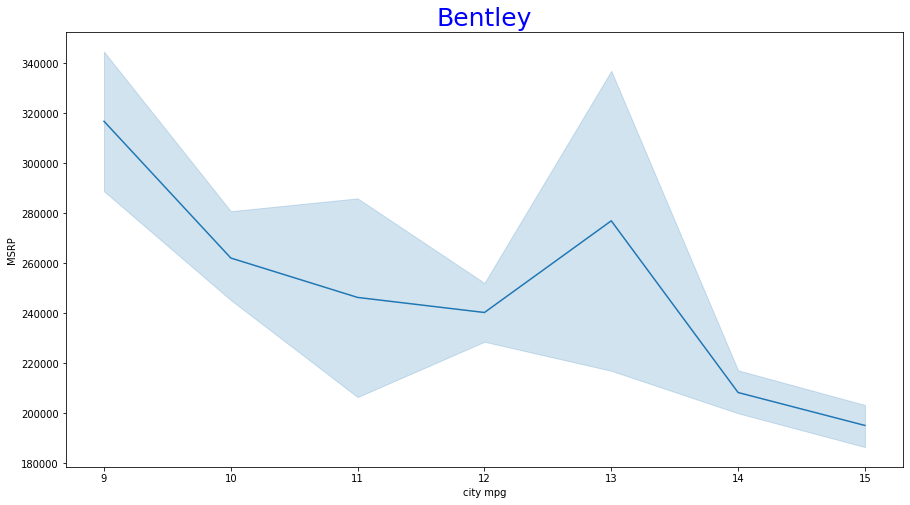

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


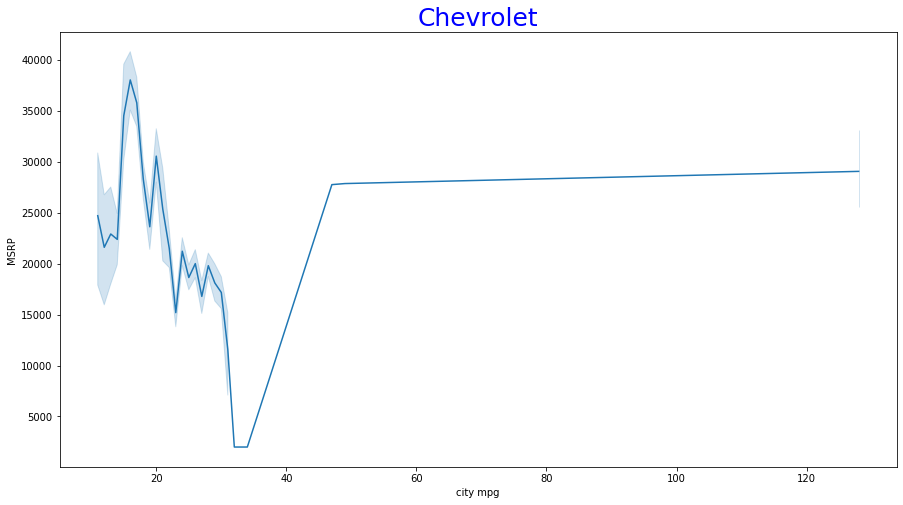

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


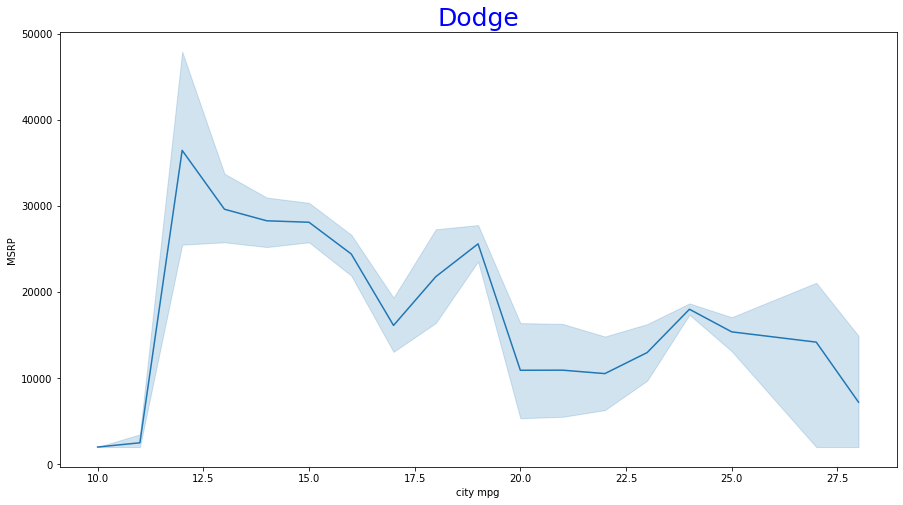

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


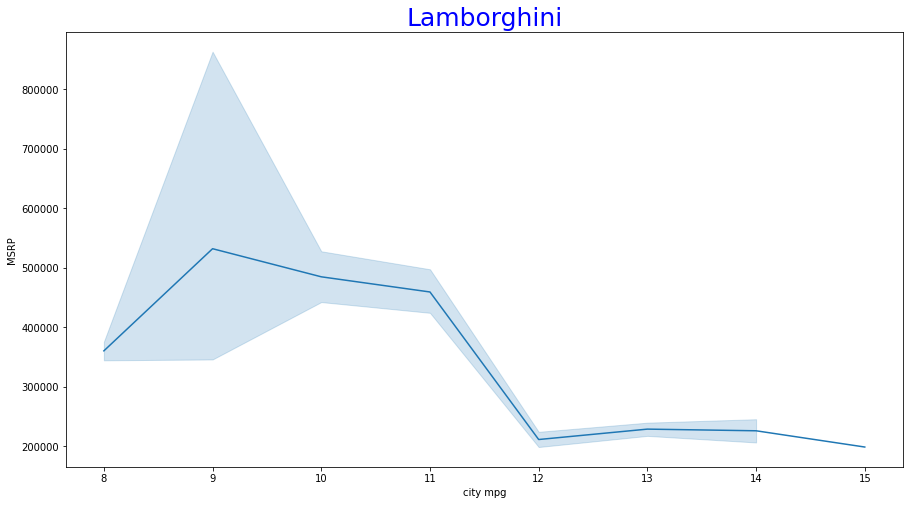

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


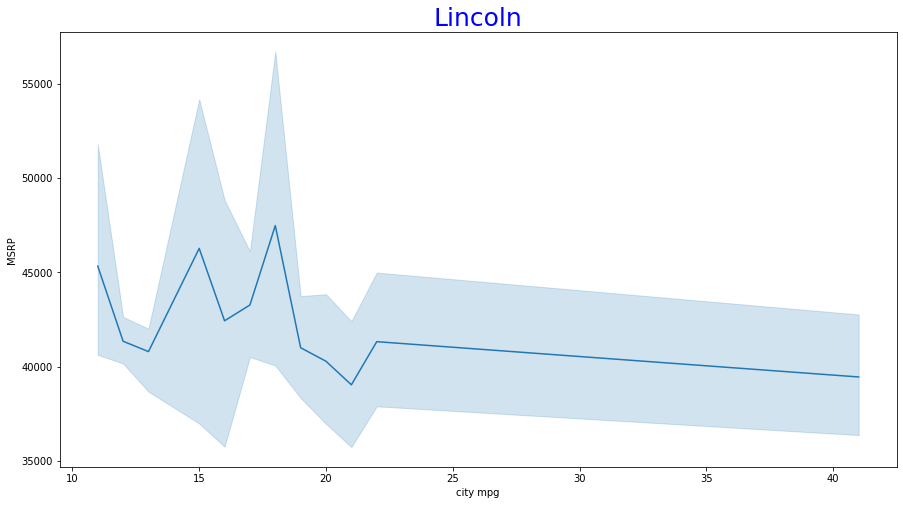

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


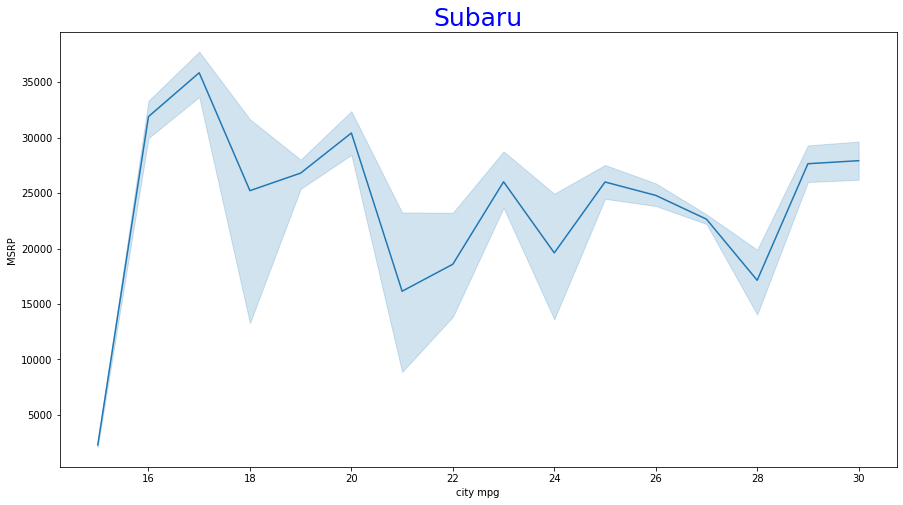

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


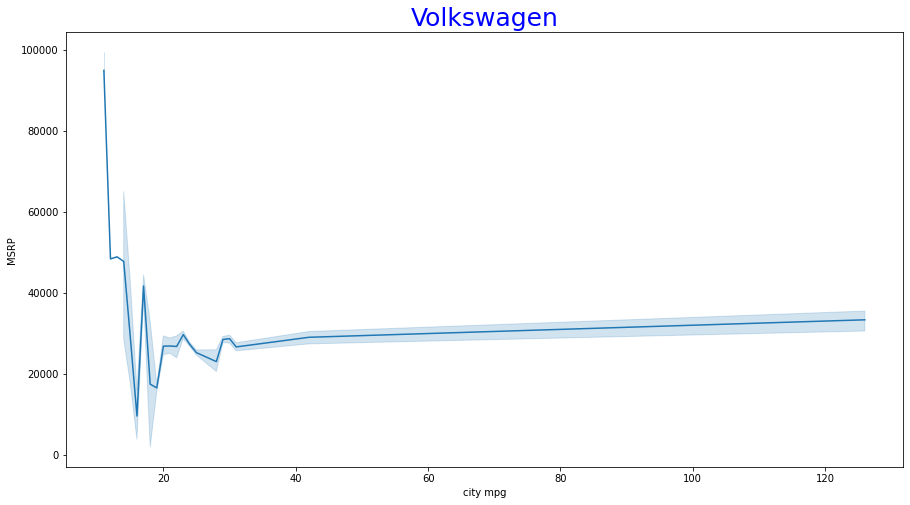

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


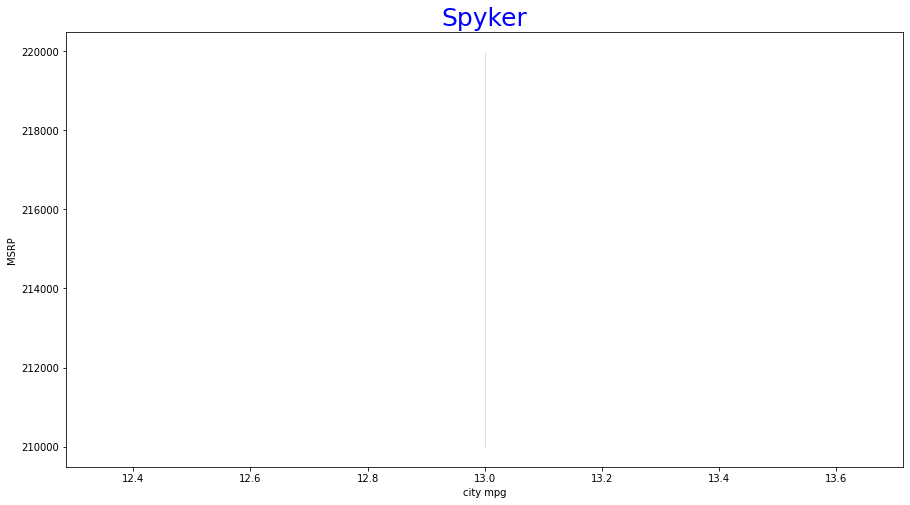

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


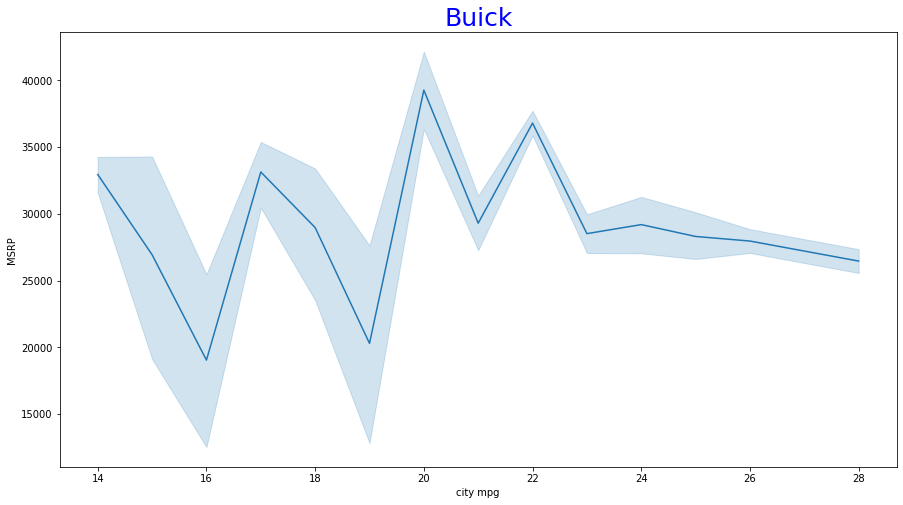

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


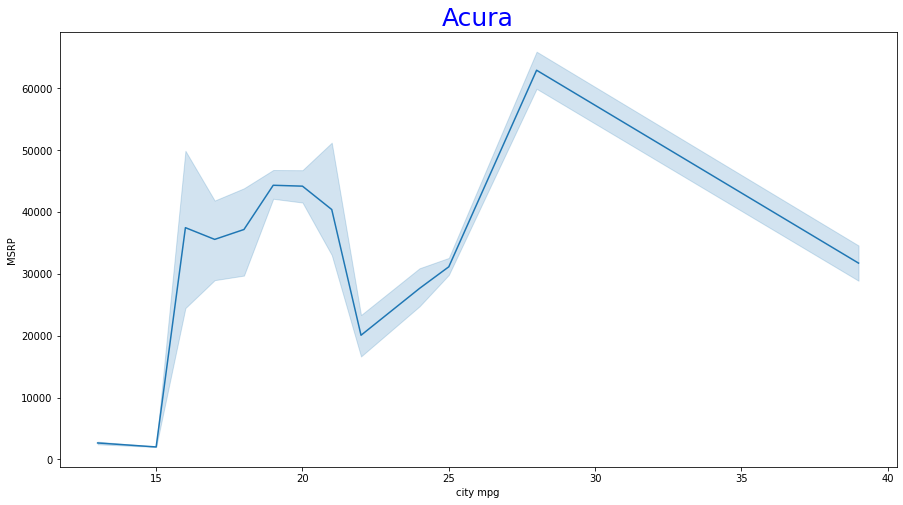

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


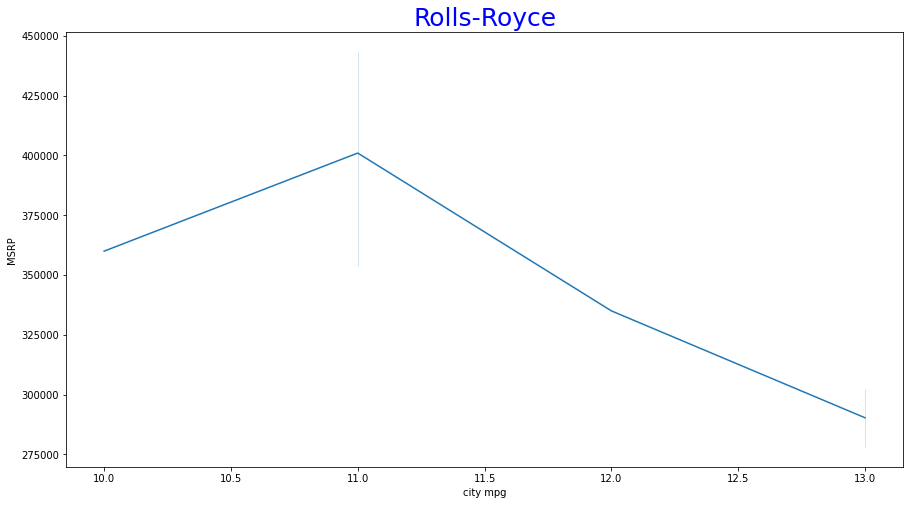

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


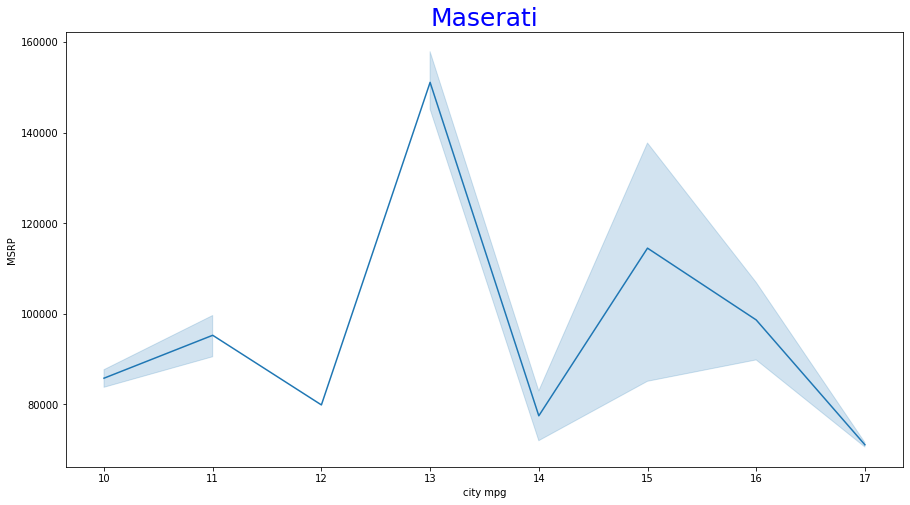

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


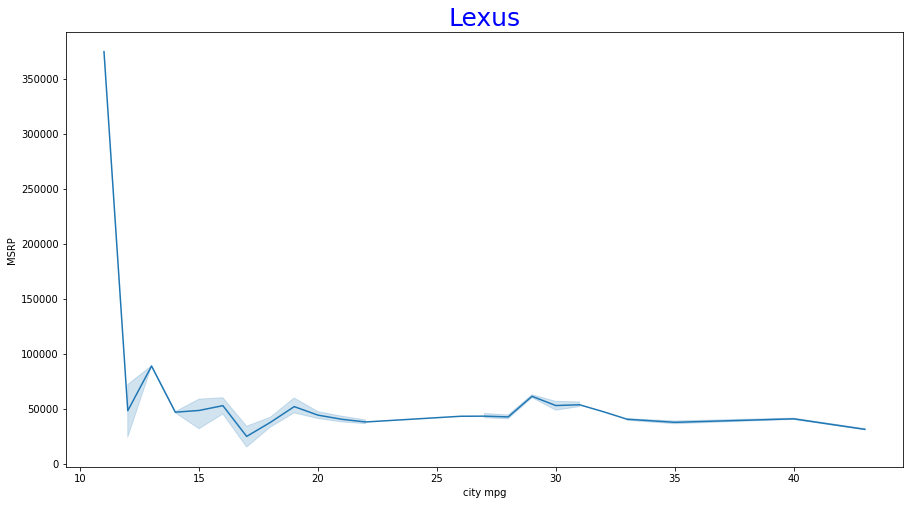

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


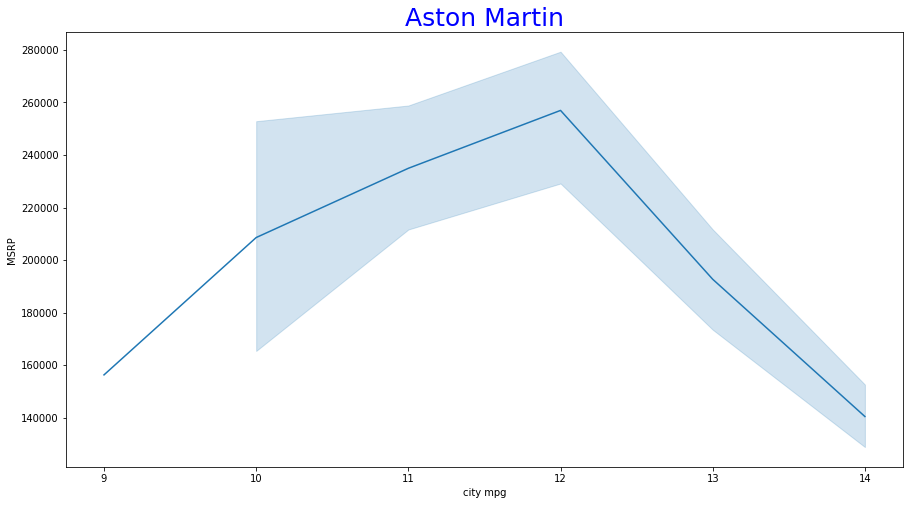

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


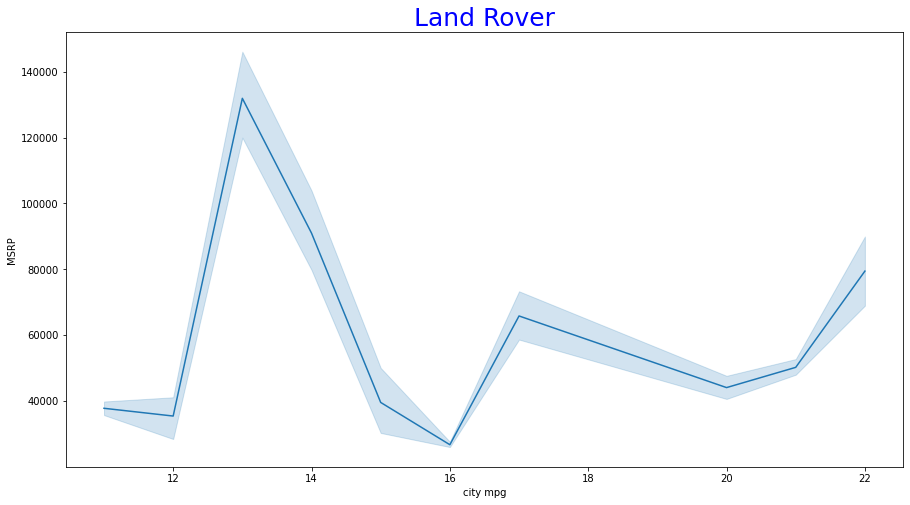

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


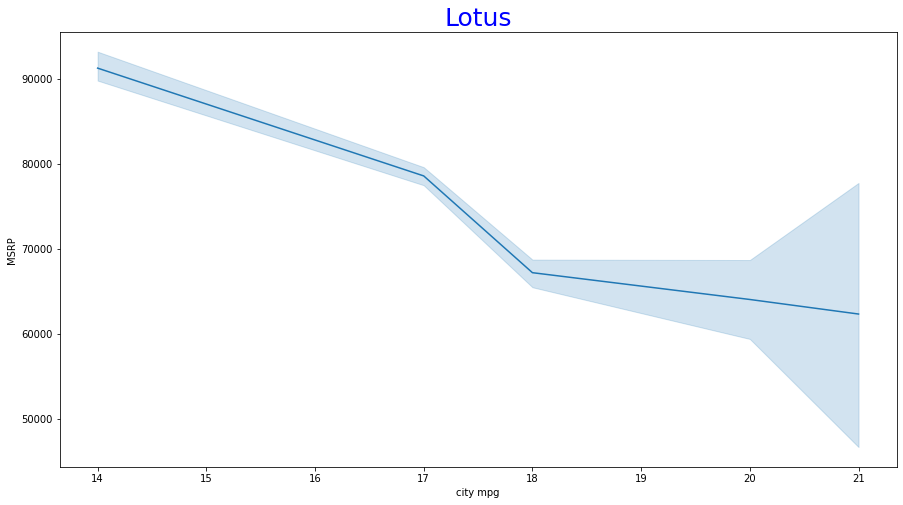

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


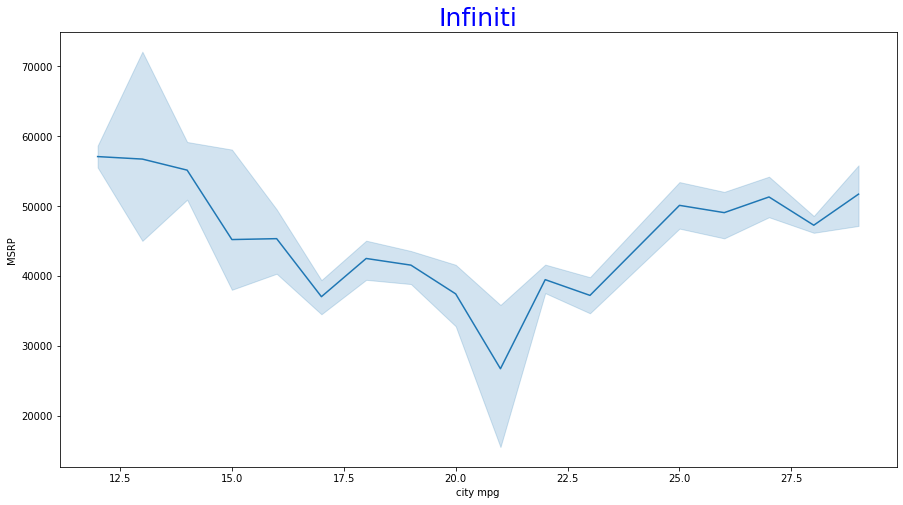

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


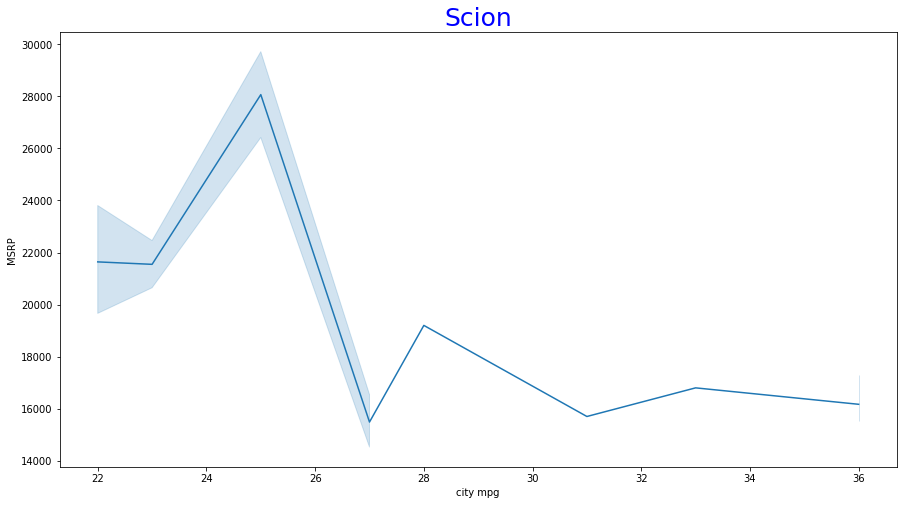

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


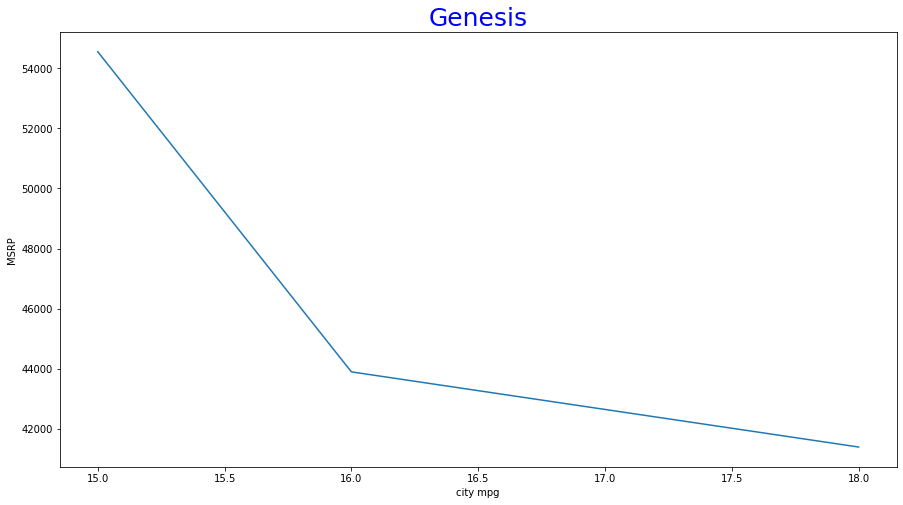

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


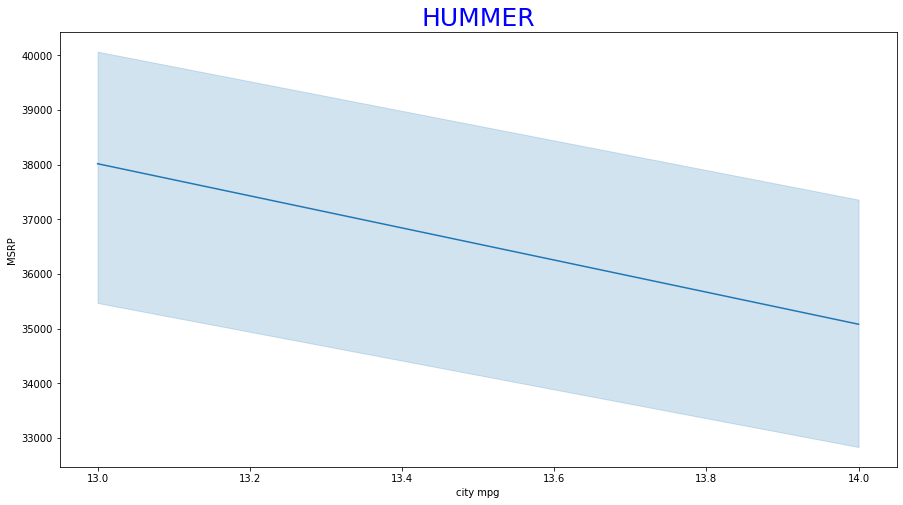

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


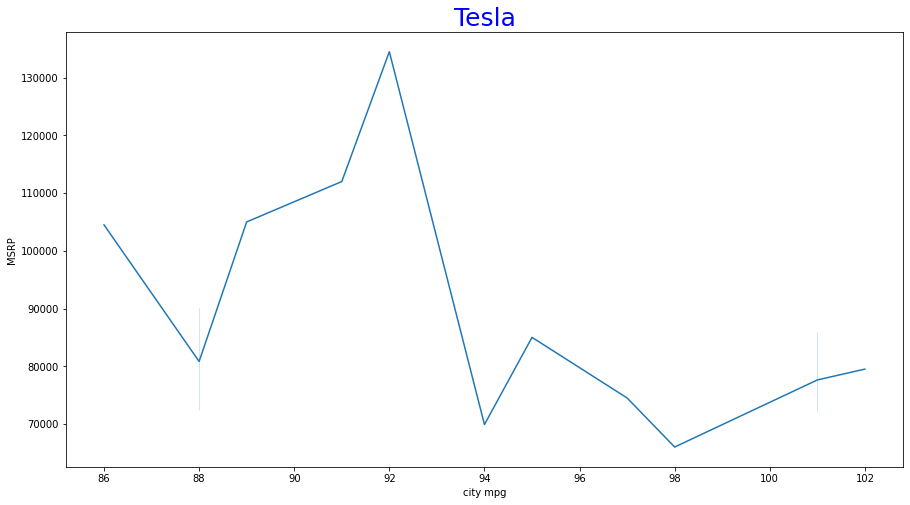

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


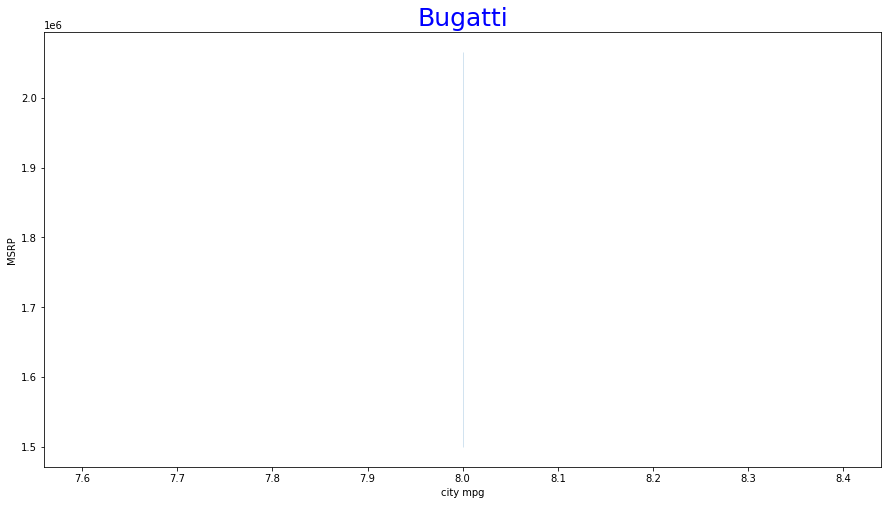

In [57]:
plt.figure(figsize=(12,9))
for i in brand:
    k = pd_df[pd_df['Make']==i]
    plt.figure(figsize = (15,8))
    sns.lineplot(k["city mpg"], k.MSRP)
    plt.title(i, {"color":"blue", "fontsize":25})
    plt.show()

# Check the brand-wise highway milage of the cars

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 864x648 with 0 Axes>

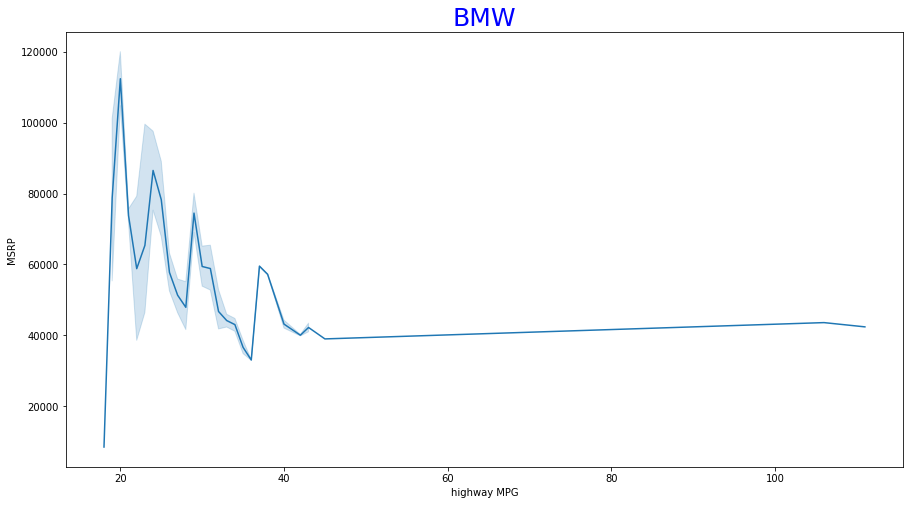

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


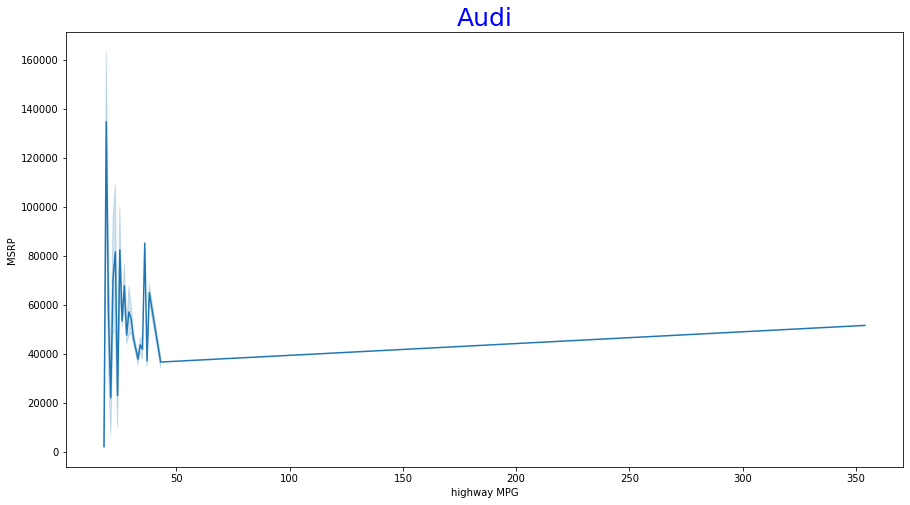

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


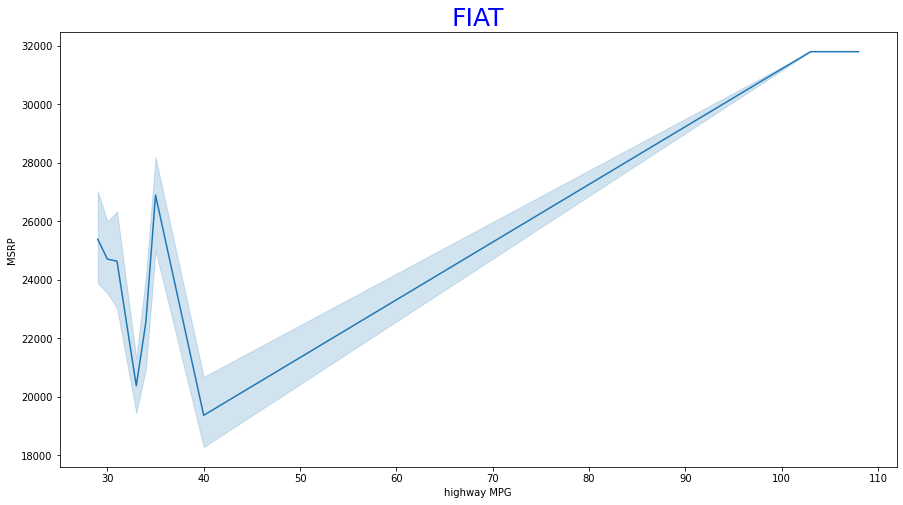

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


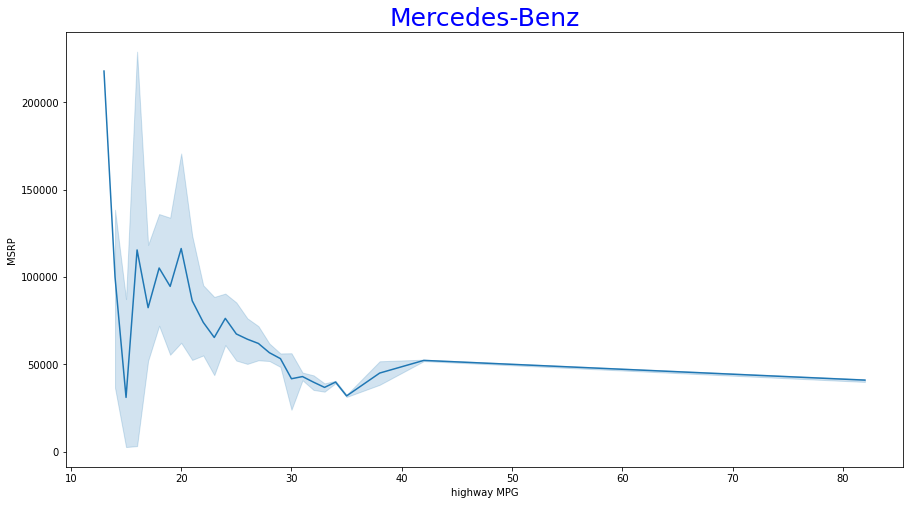

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


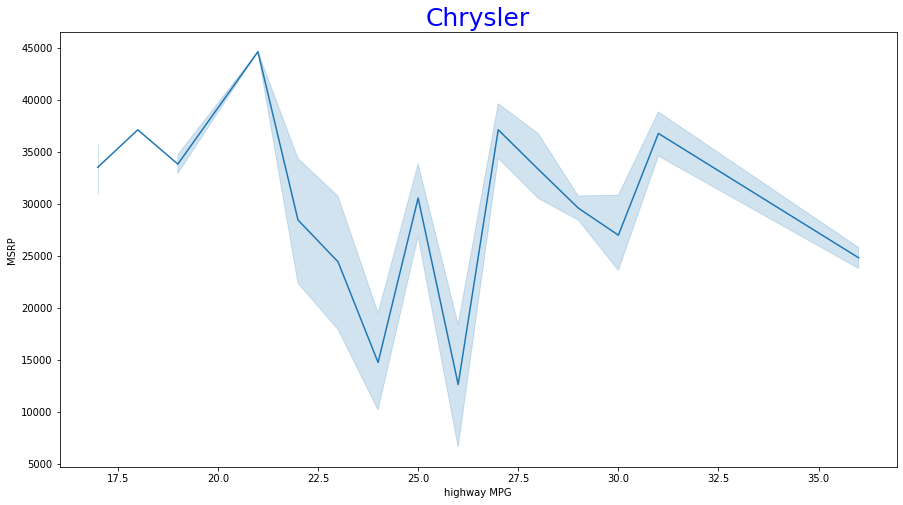

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


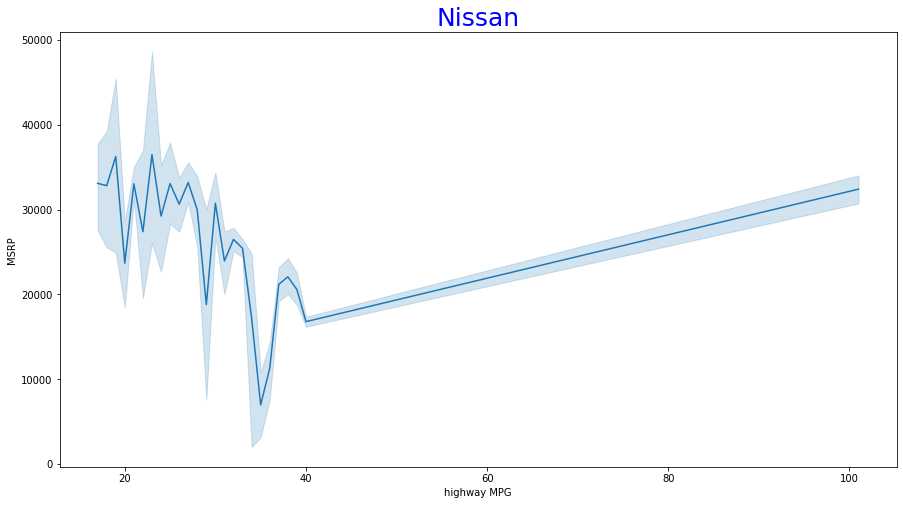

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


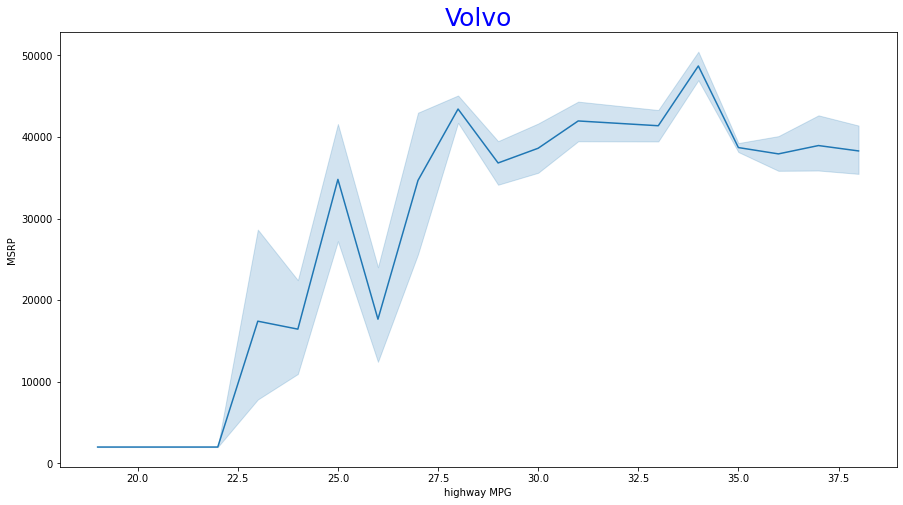

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


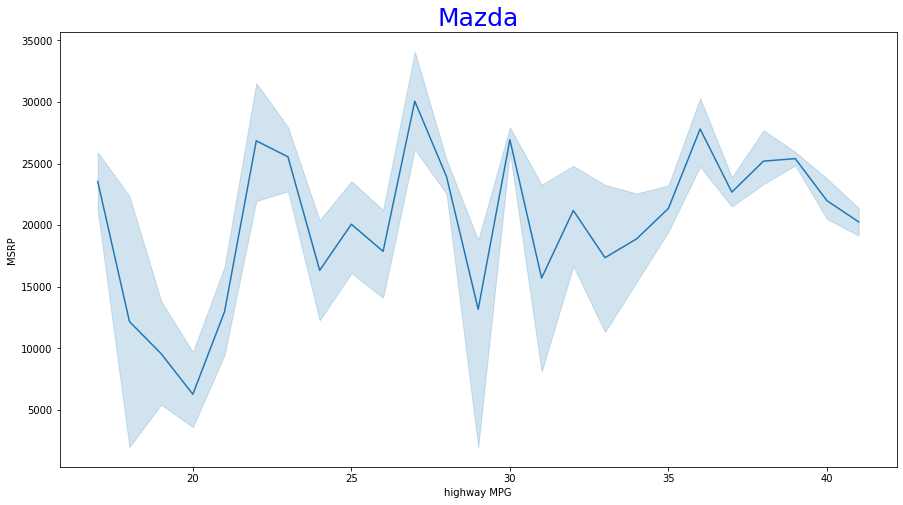

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


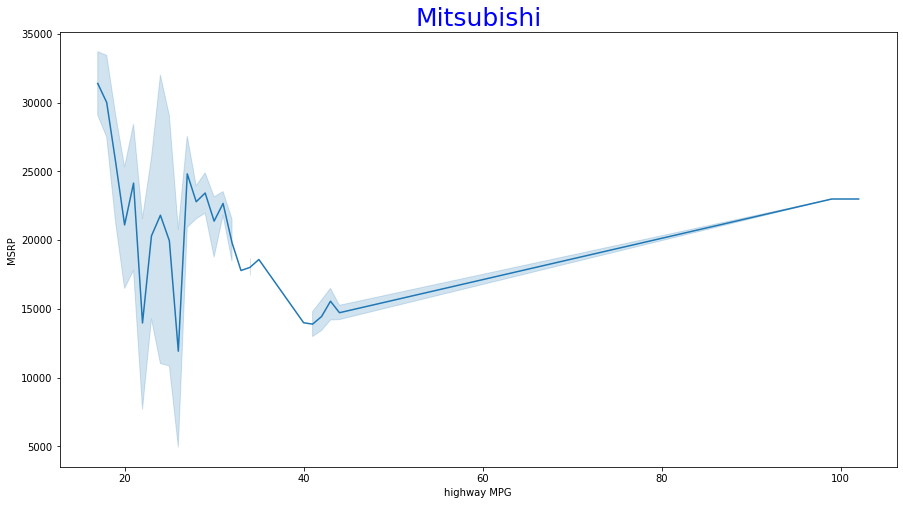

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


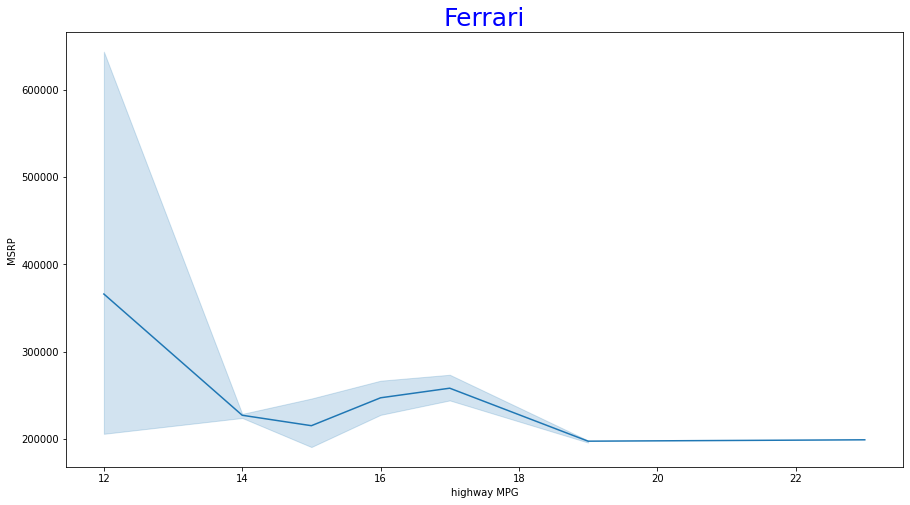

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


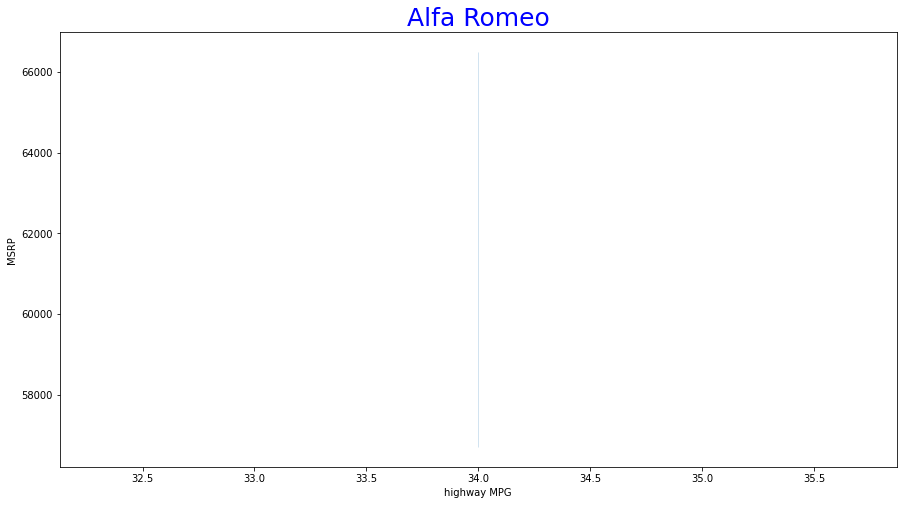

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


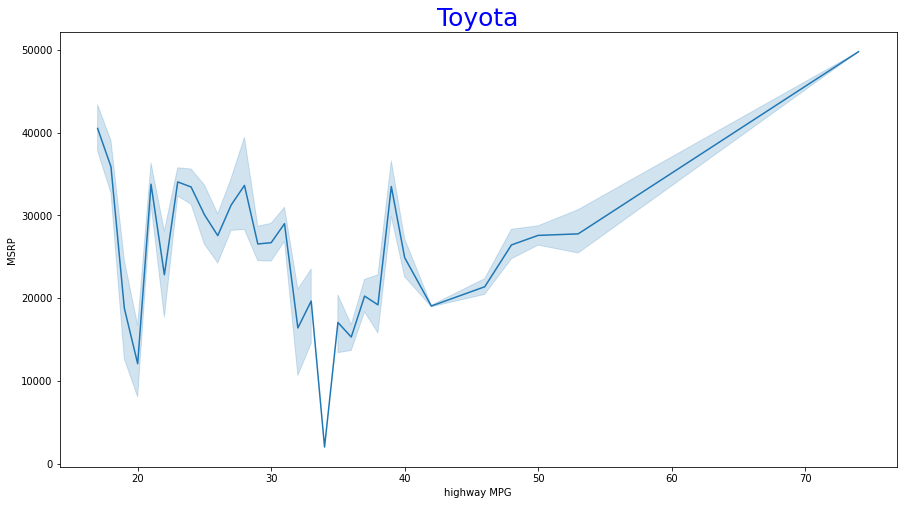

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


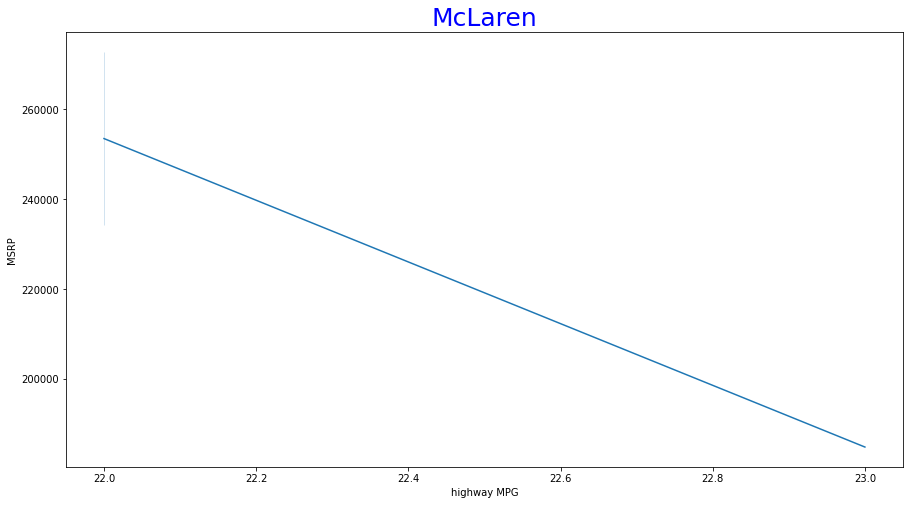

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


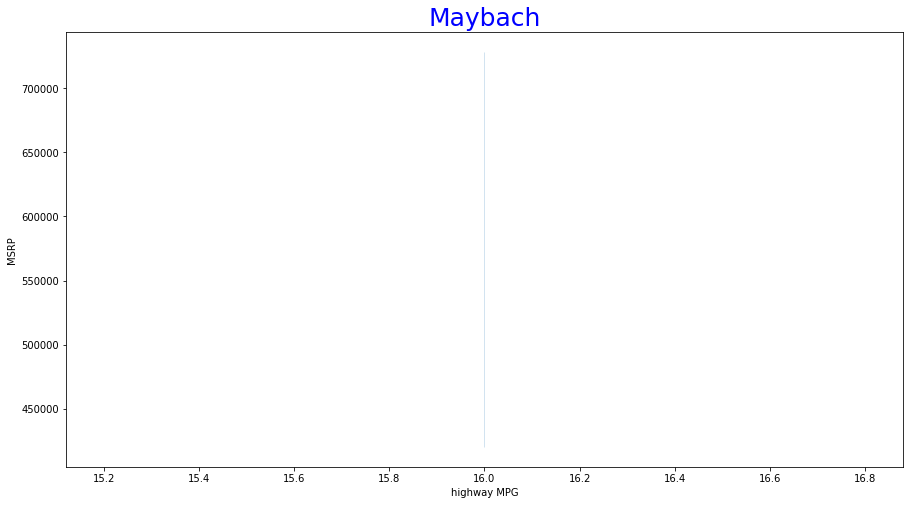

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


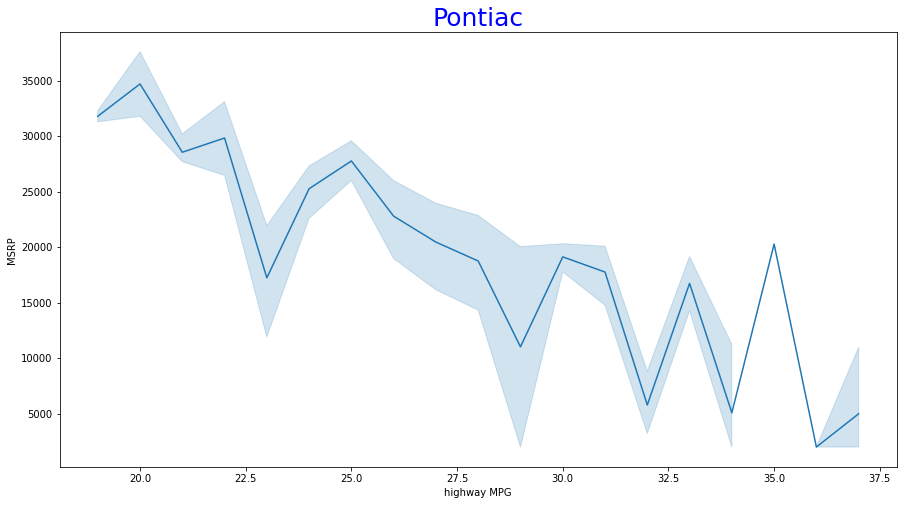

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


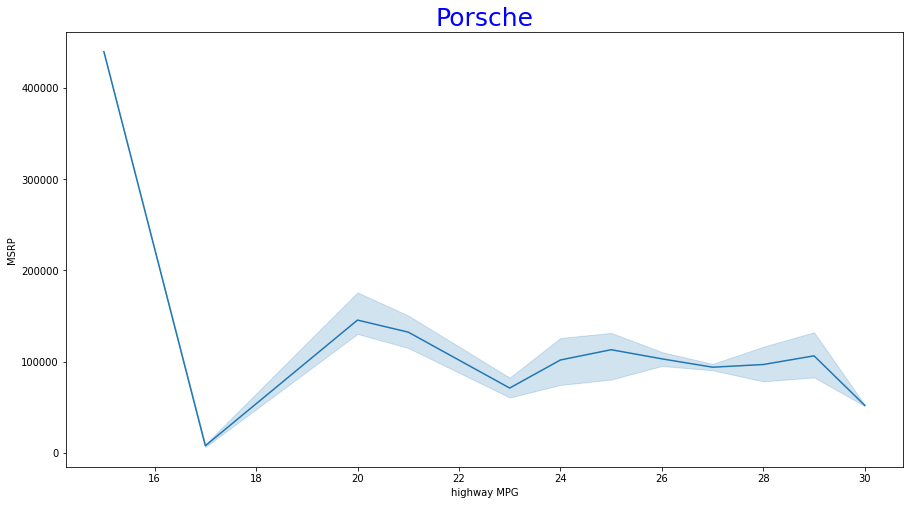

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


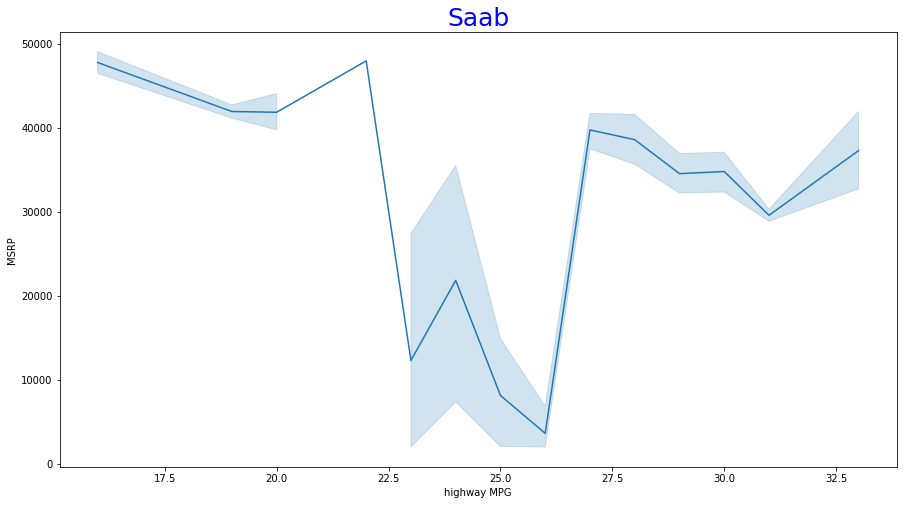

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


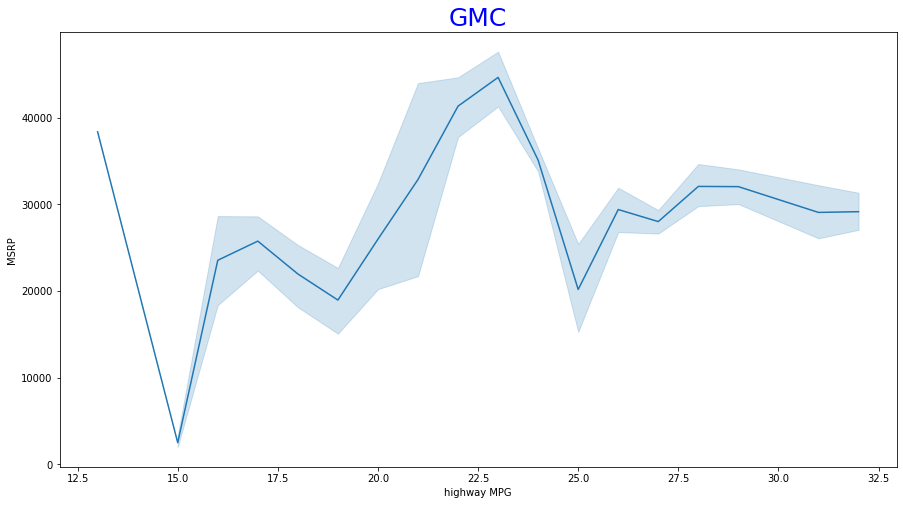

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


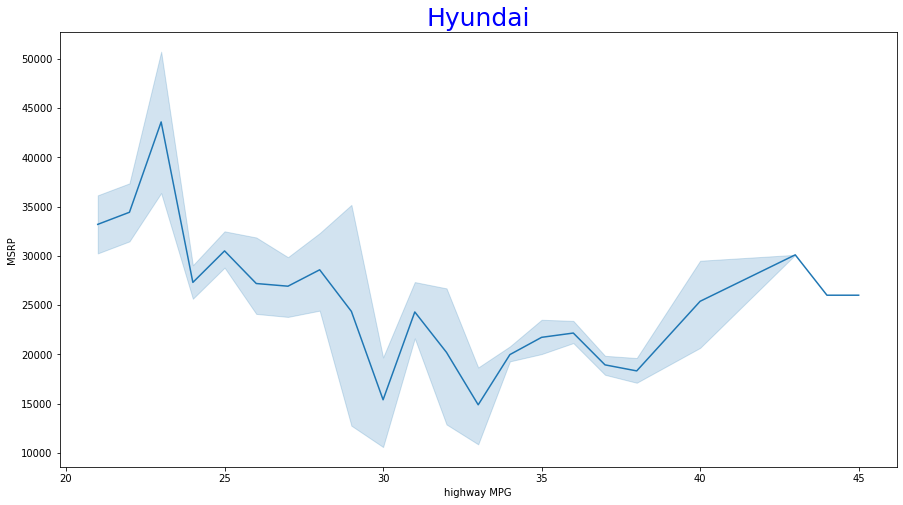

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


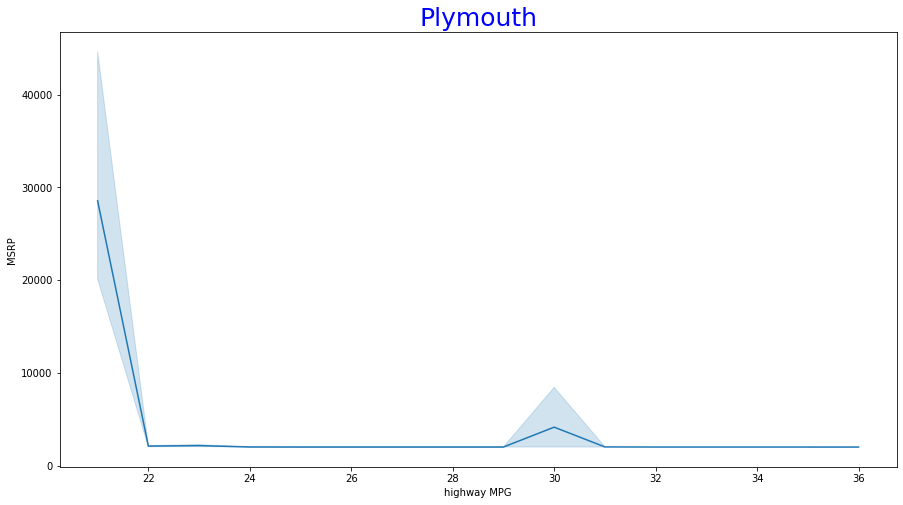

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


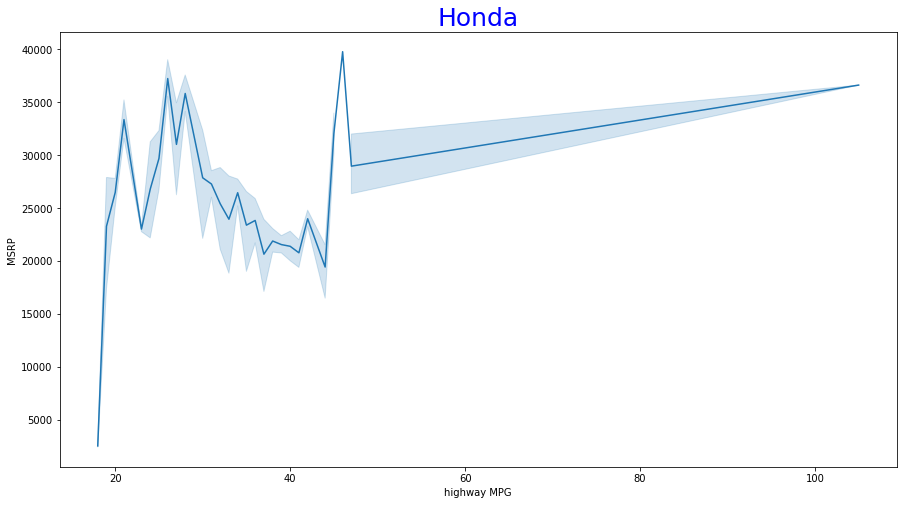

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


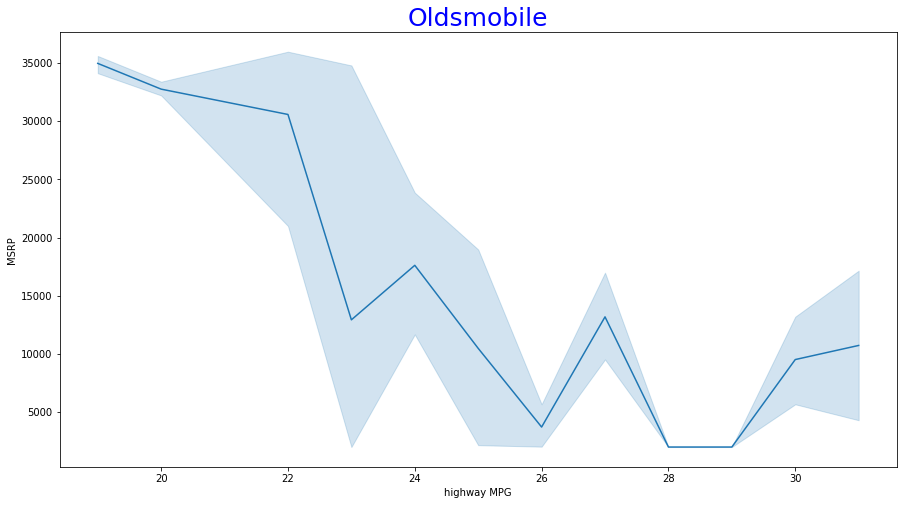

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


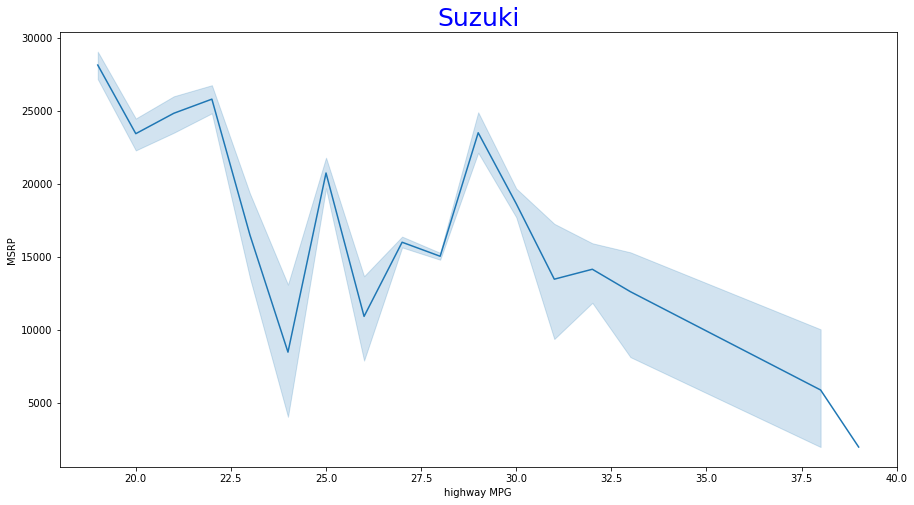

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


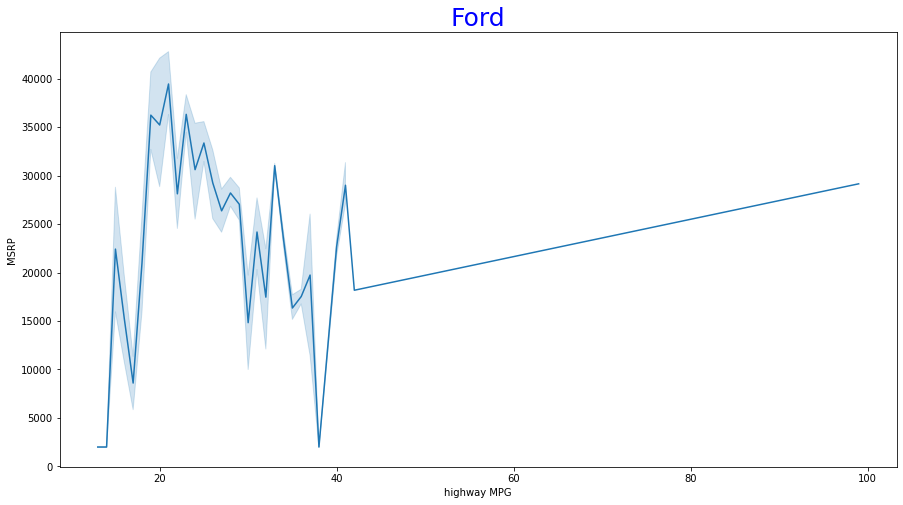

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


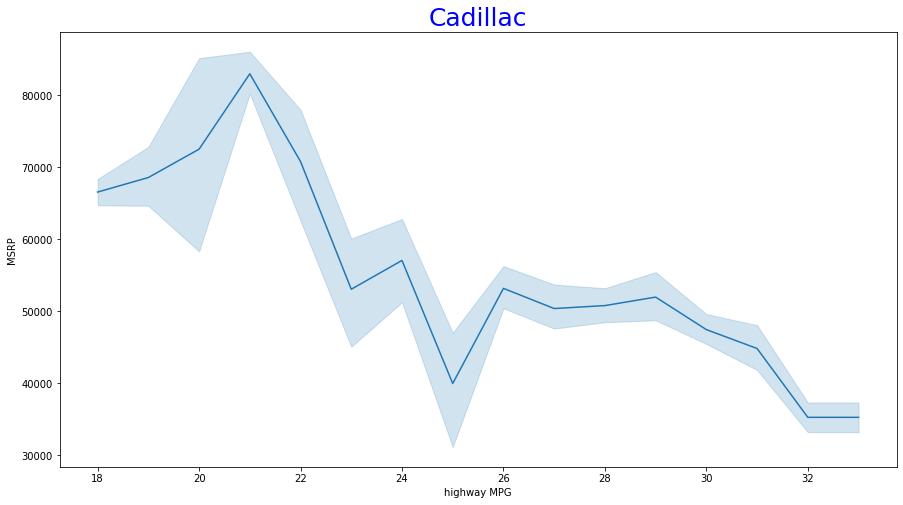

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


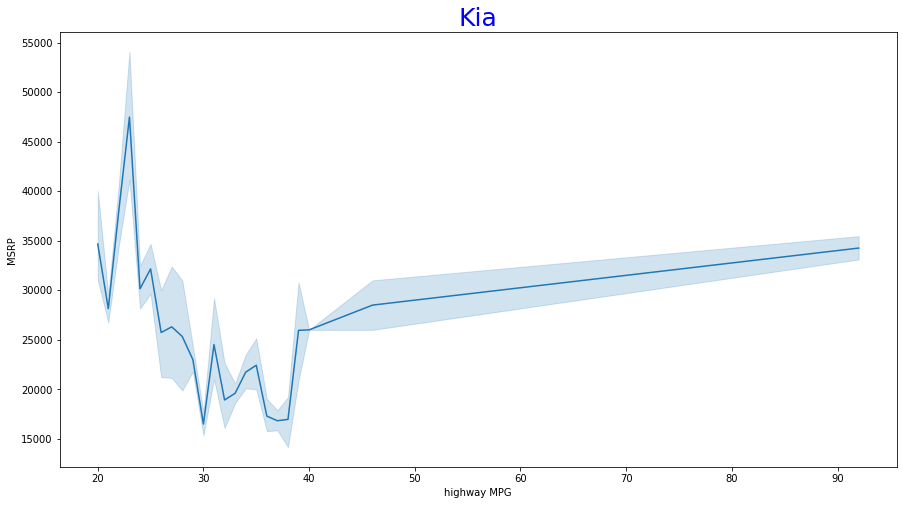

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


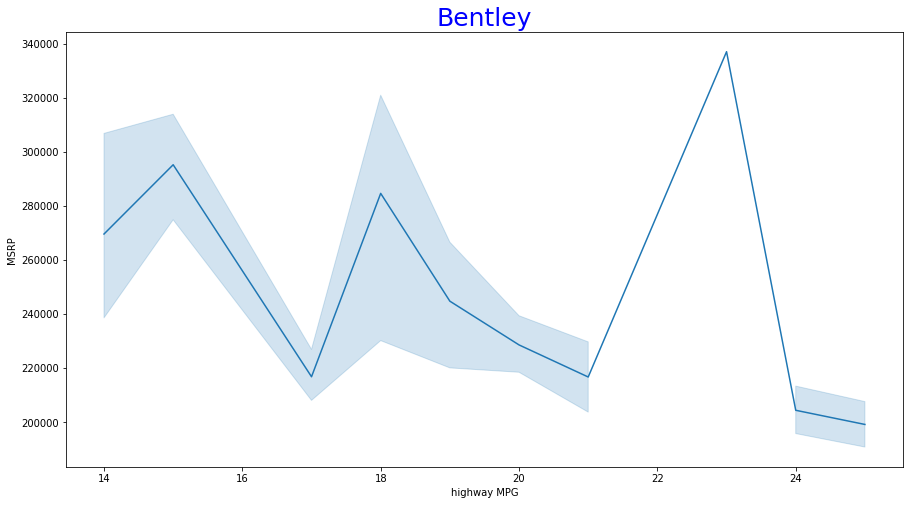

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


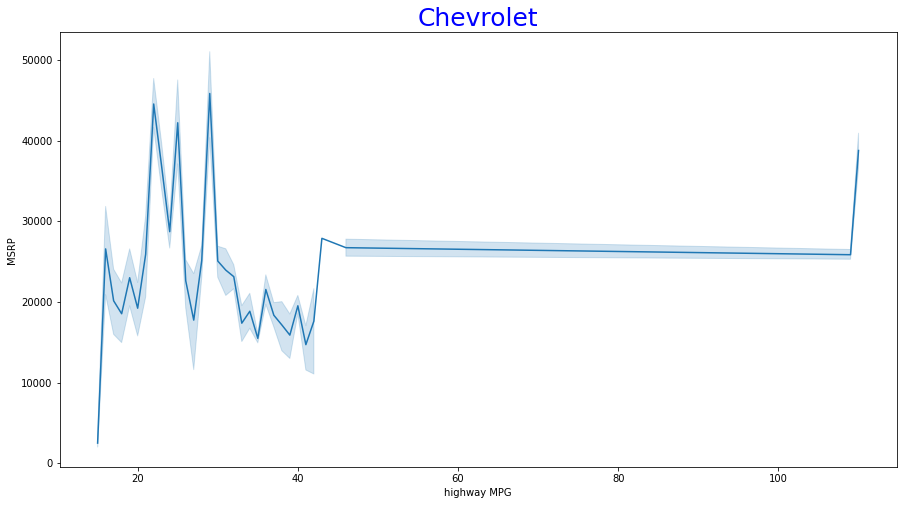

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


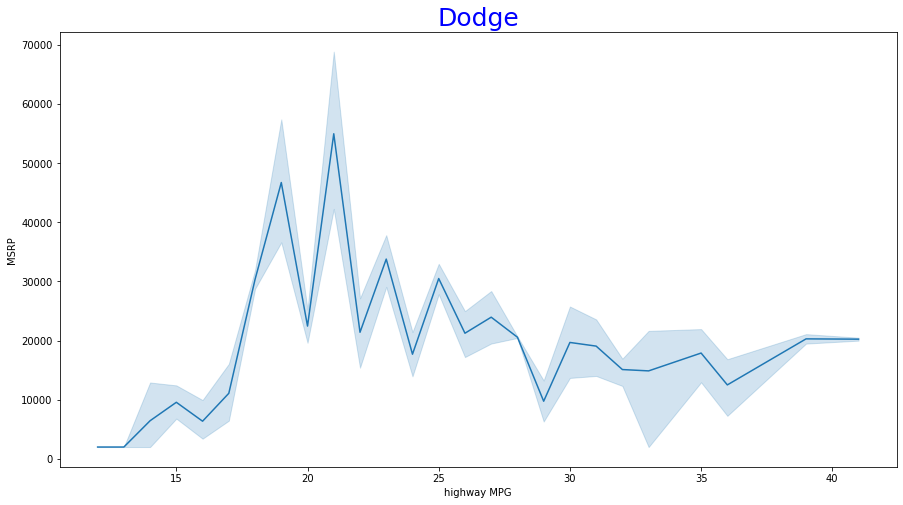

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


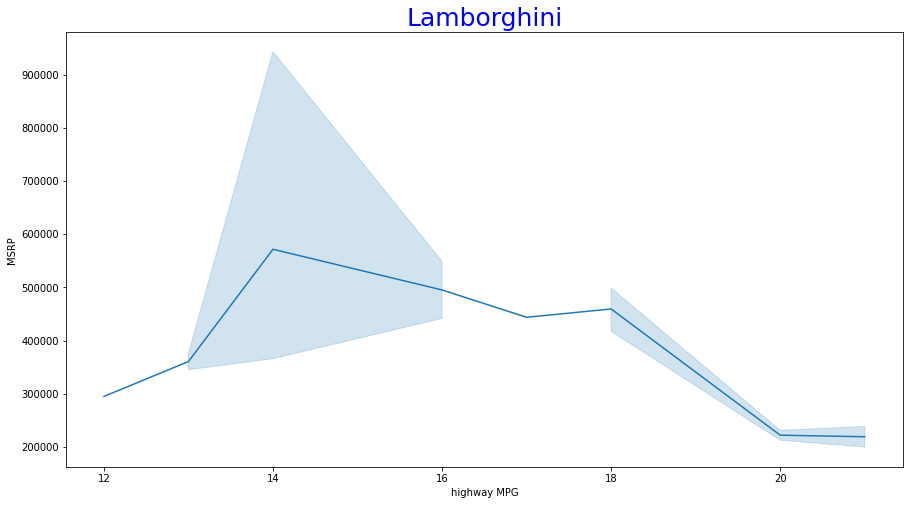

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


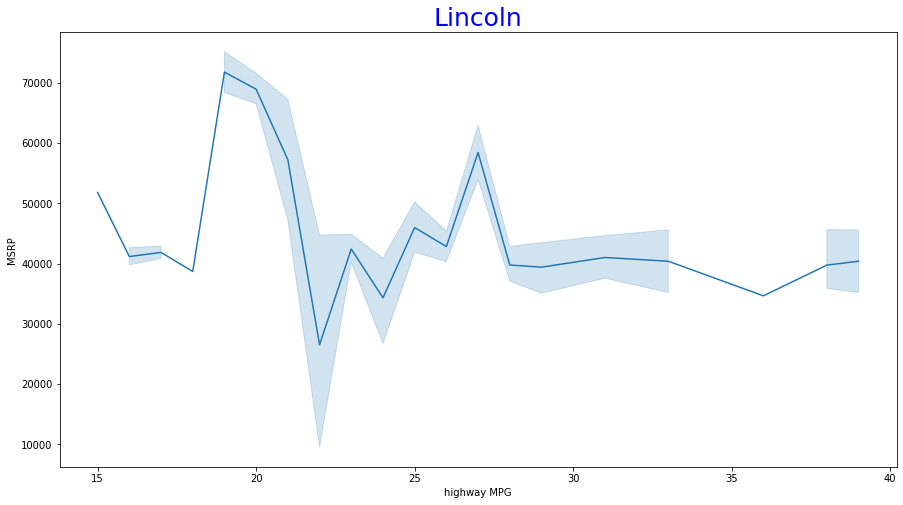

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


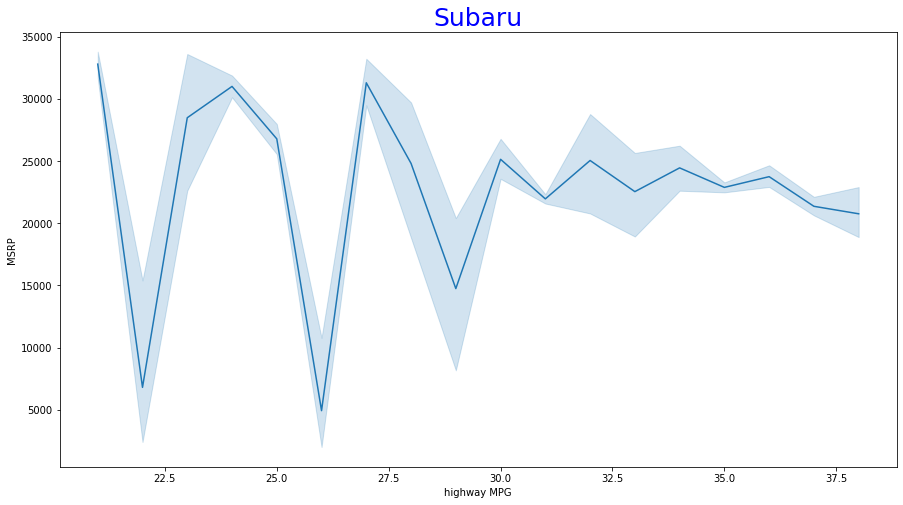

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


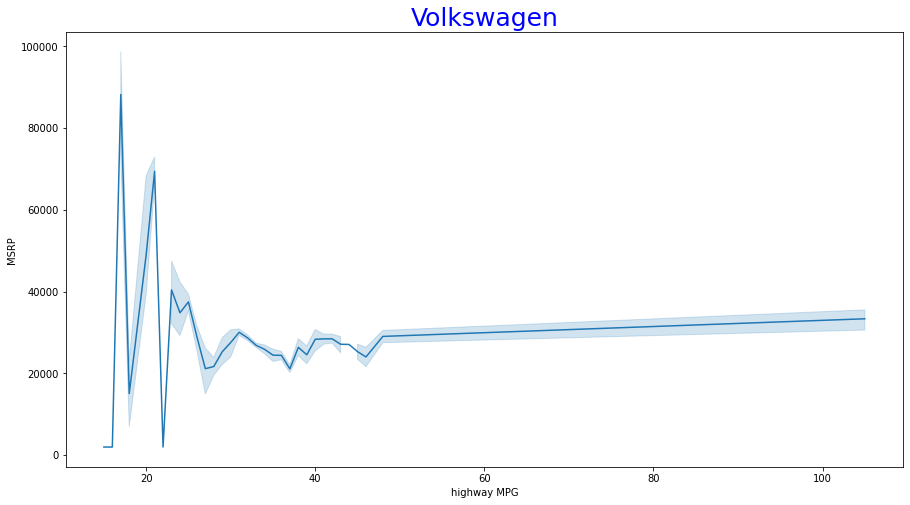

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


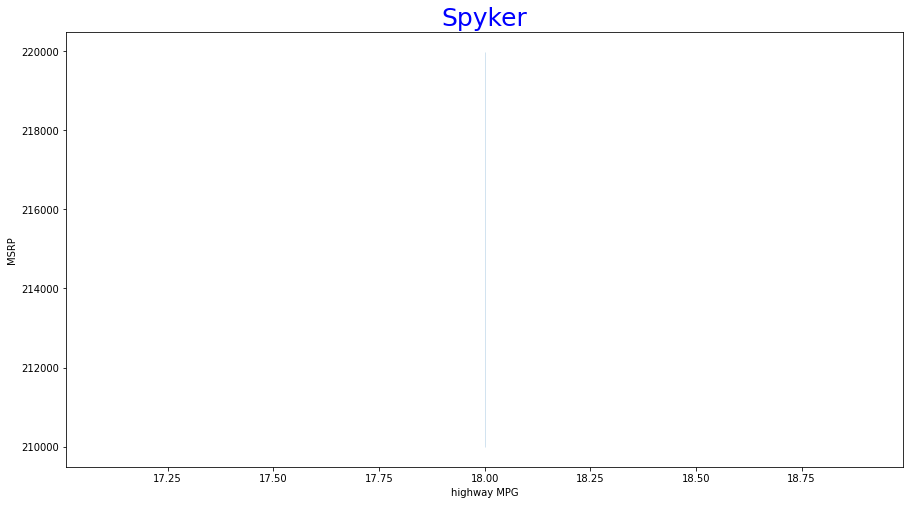

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


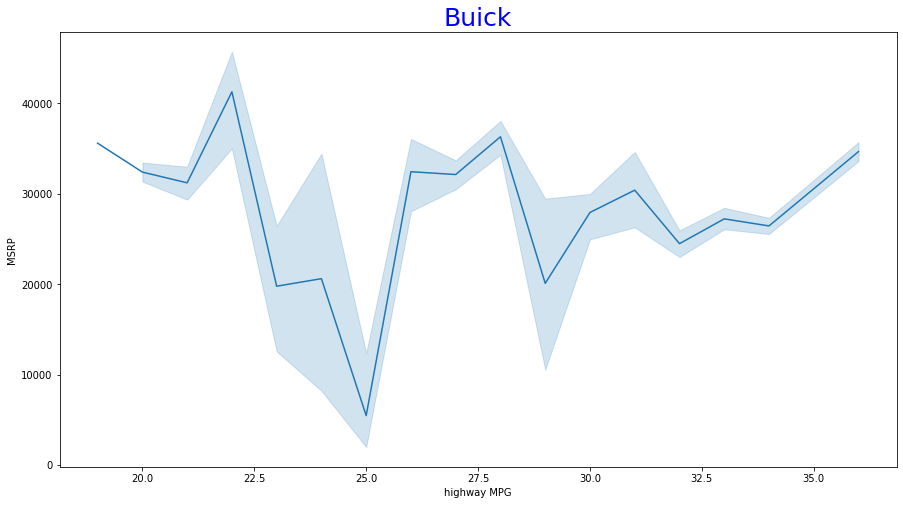

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


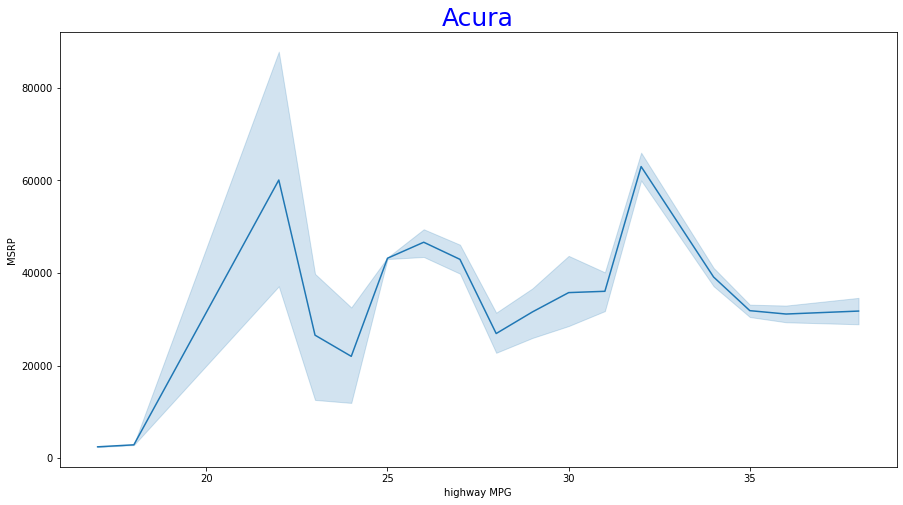

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


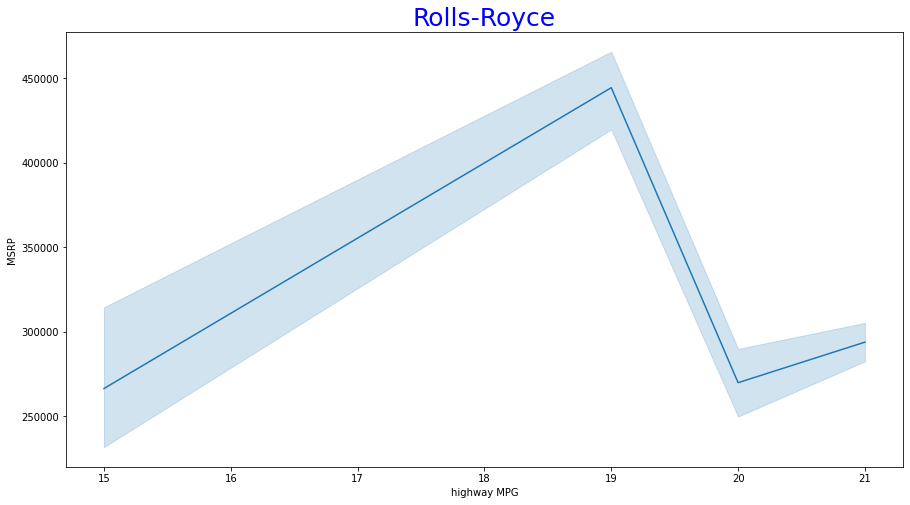

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


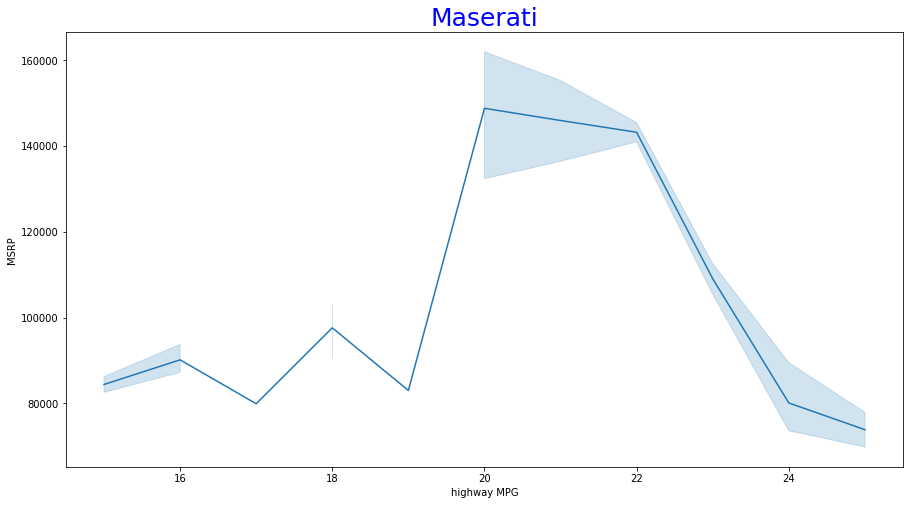

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


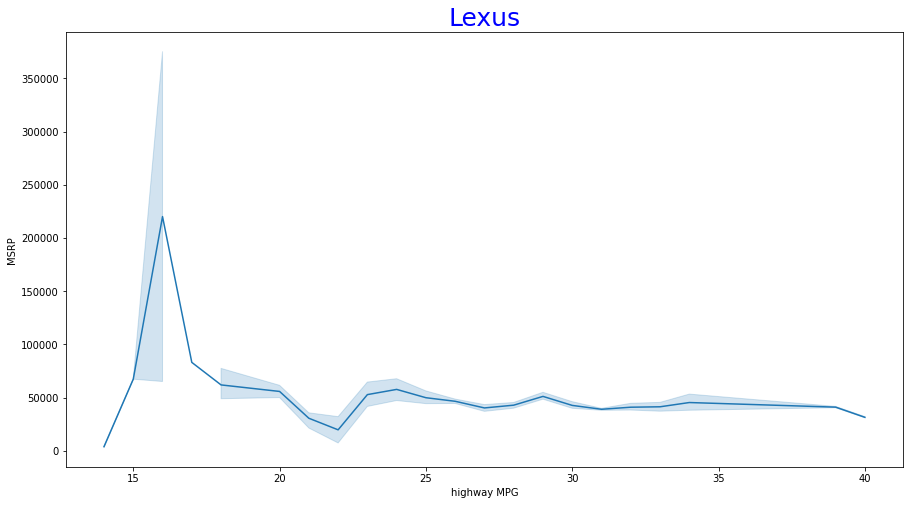

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


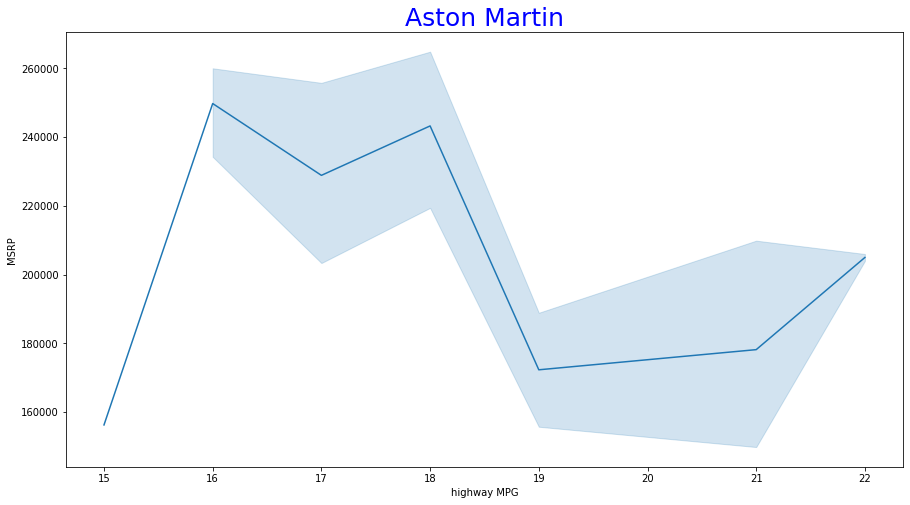

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


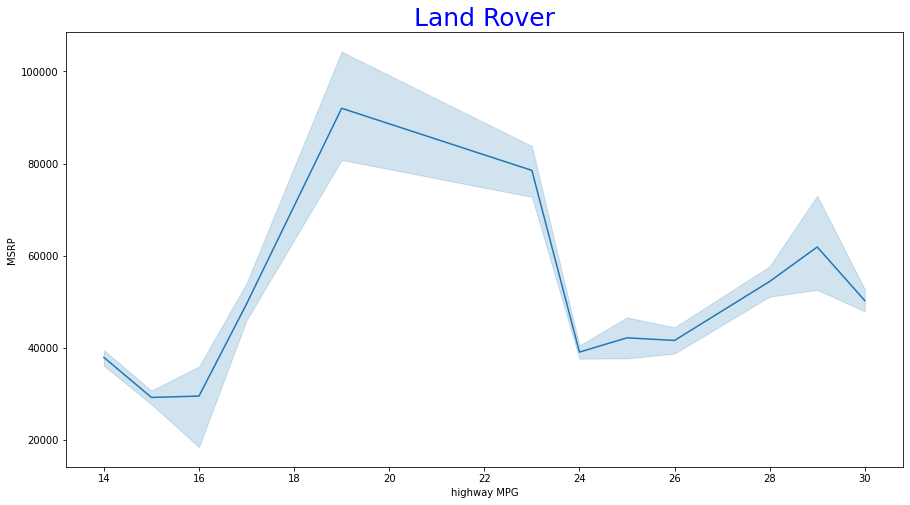

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


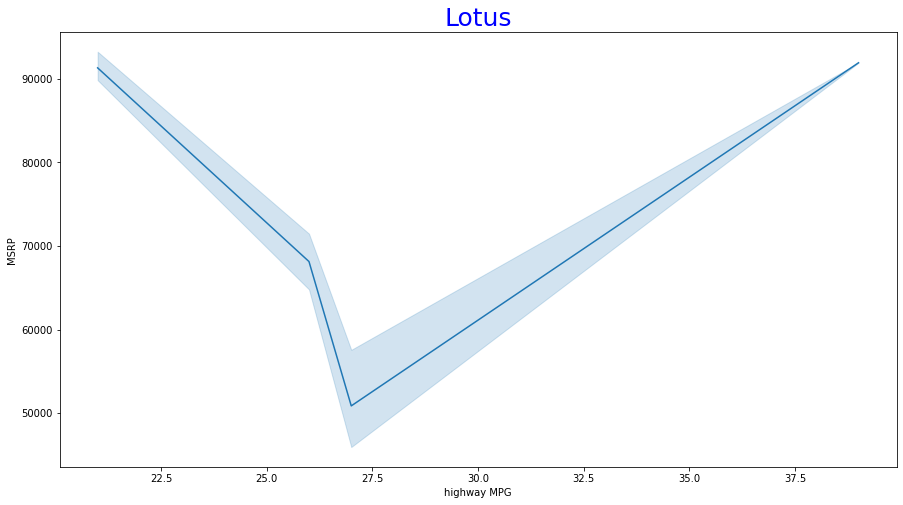

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


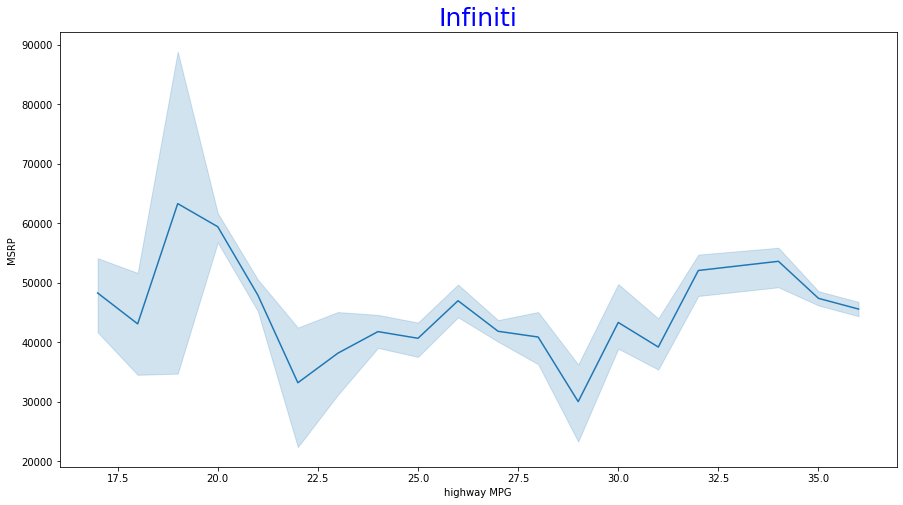

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


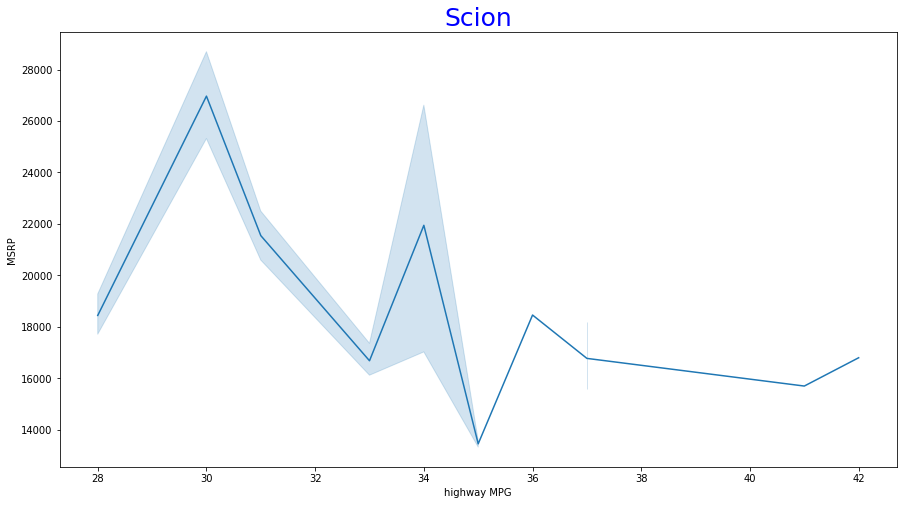

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


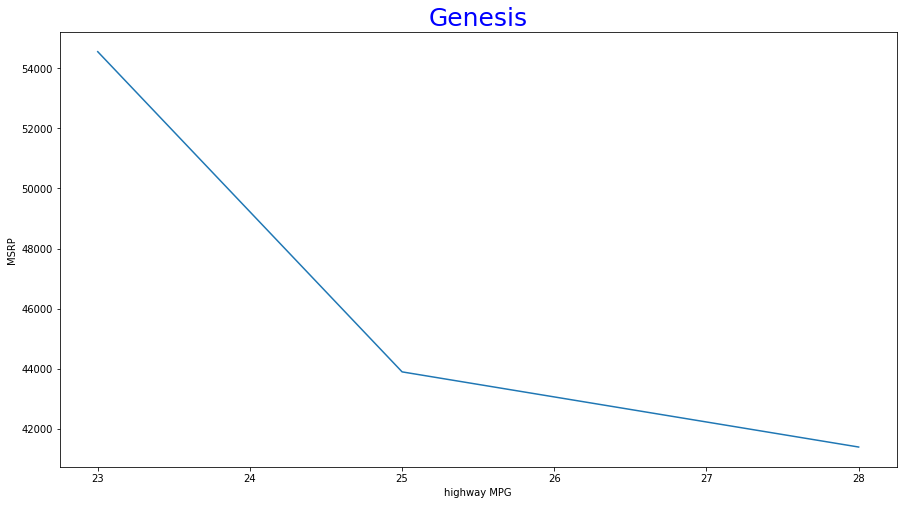

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


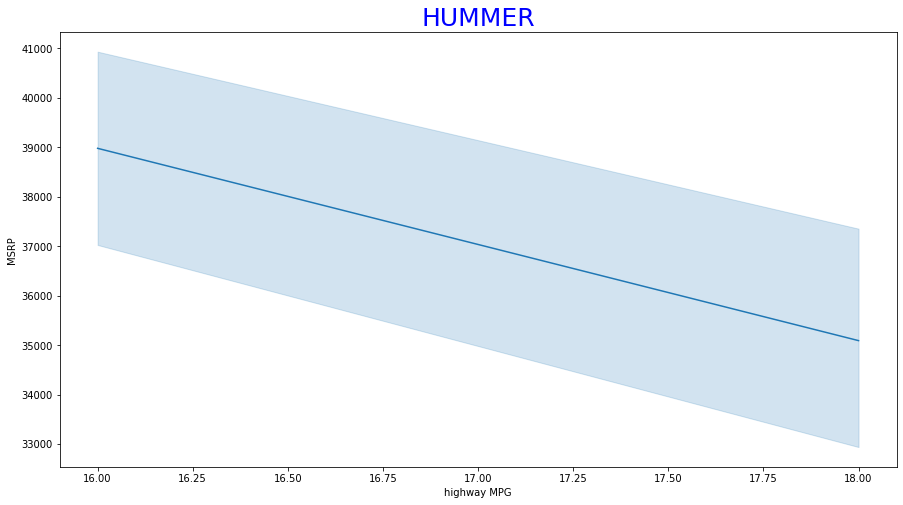

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


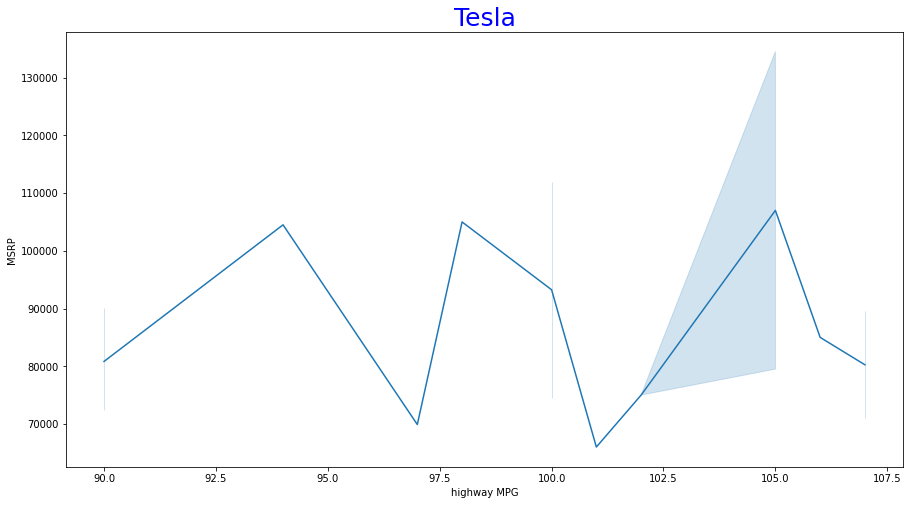

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


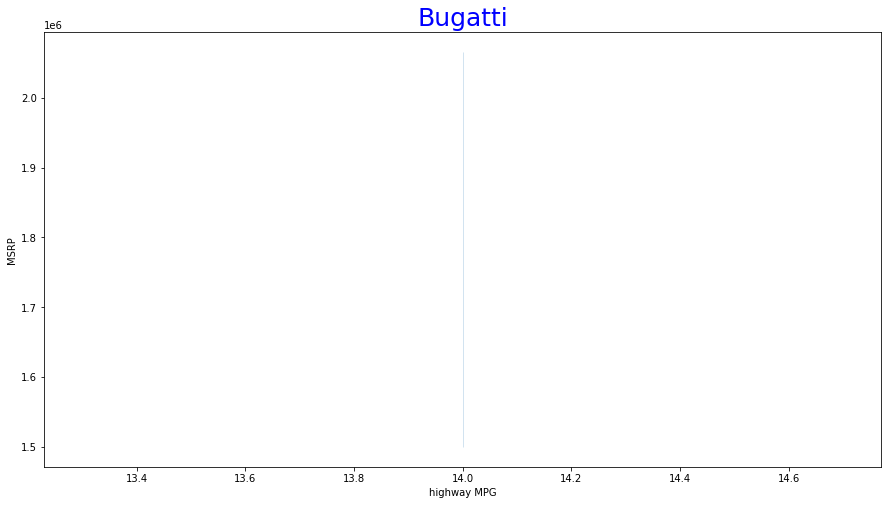

In [60]:
plt.figure(figsize=(12,9))
for i in brand:
    k = pd_df[pd_df['Make']==i]
    plt.figure(figsize = (15,8))
    sns.lineplot(k["highway MPG"], k.MSRP)
    plt.title(i, {"color":"blue", "fontsize":25})
    plt.show()

# View the prices of the various cars based on size and style

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Prices of the various cars based on size and style')

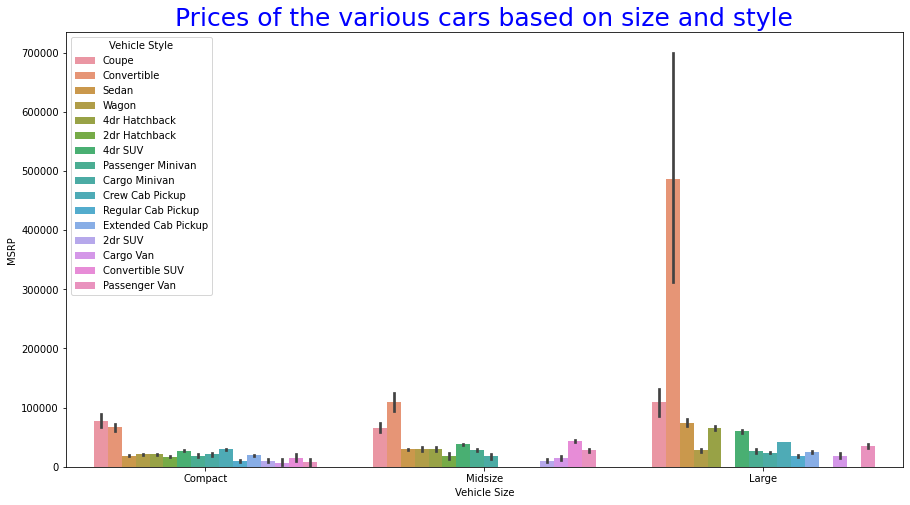

In [61]:
plt.figure(figsize=(15,8))
sns.barplot(pd_df["Vehicle Size"], pd_df.MSRP,hue=pd_df['Vehicle Style'])
plt.title("Prices of the various cars based on size and style", {"color":"blue", "fontsize":25})

# View the prices of the various cars based on size and wheel type

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Prices of the various cars based on size and wheel type')

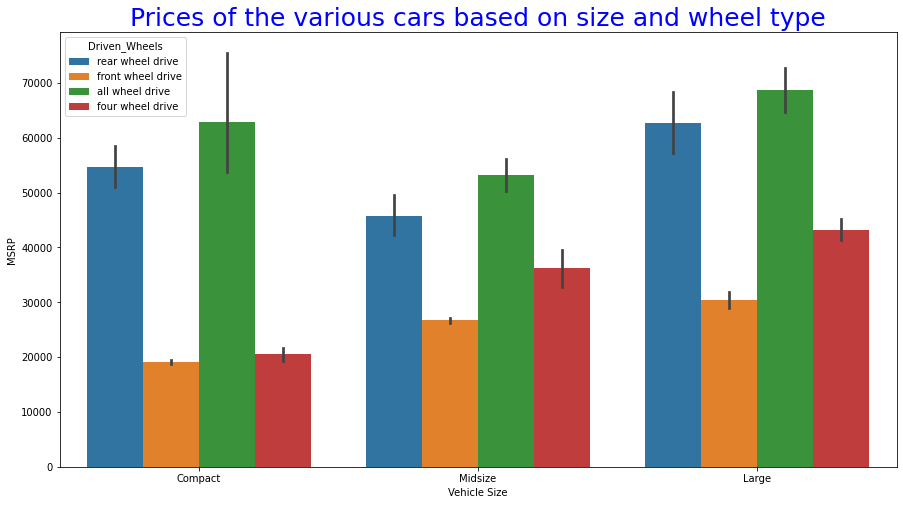

In [62]:
plt.figure(figsize=(15,8))
sns.barplot(pd_df["Vehicle Size"], pd_df.MSRP,hue=pd_df['Driven_Wheels'])
plt.title("Prices of the various cars based on size and wheel type", {"color":"blue", "fontsize":25})

# View the prices of the various cars based on size and transmission type

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Prices of the various cars based on size and transmission type')

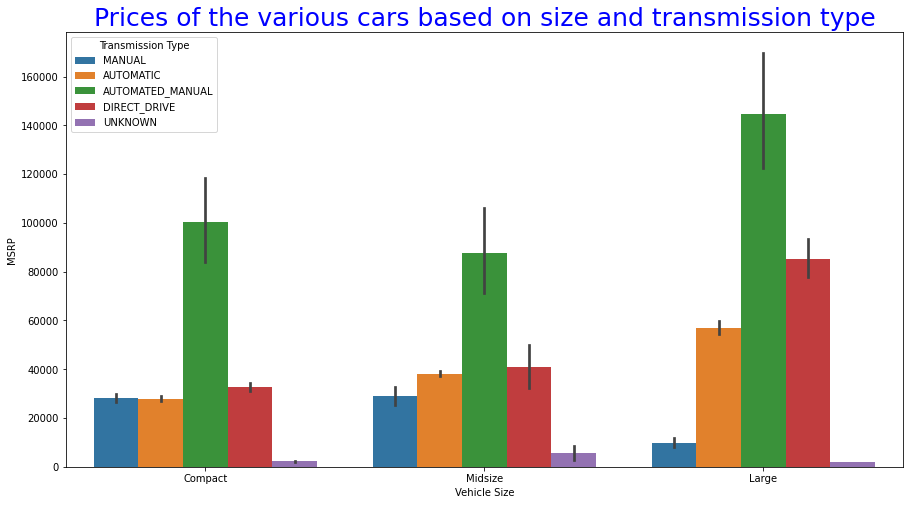

In [63]:
plt.figure(figsize=(15,8))
sns.barplot(pd_df["Vehicle Size"], pd_df.MSRP,hue=pd_df['Transmission Type'])
plt.title("Prices of the various cars based on size and transmission type", {"color":"blue", "fontsize":25})

# Plot the heatmap

Text(0.5, 1.0, 'Correlation plot')

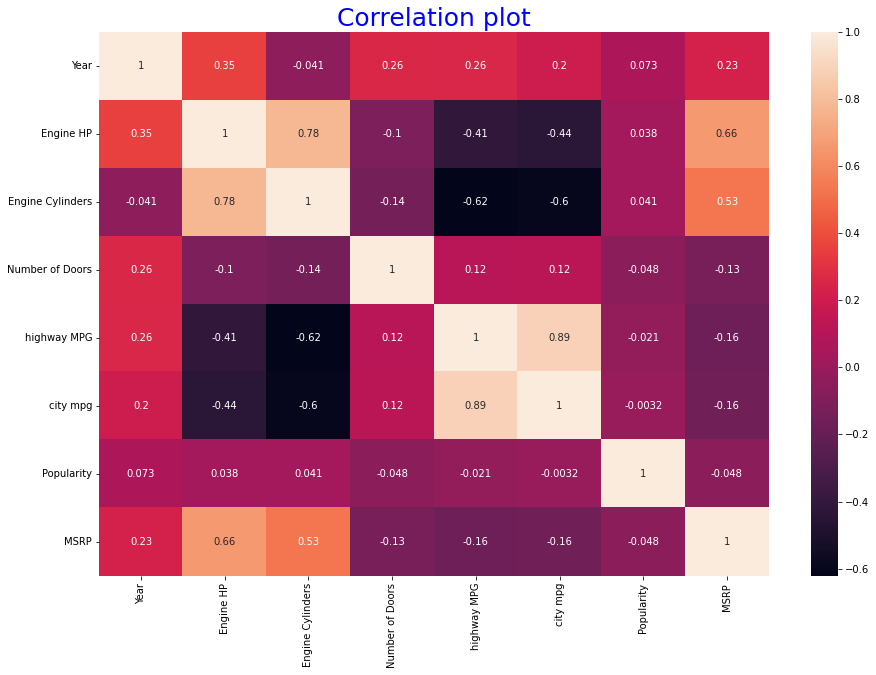

In [64]:
plt.figure(figsize=(15,10))
sns.heatmap(pd_df.corr(),annot=True)
plt.title("Correlation plot", {"color":"blue", "fontsize":25})

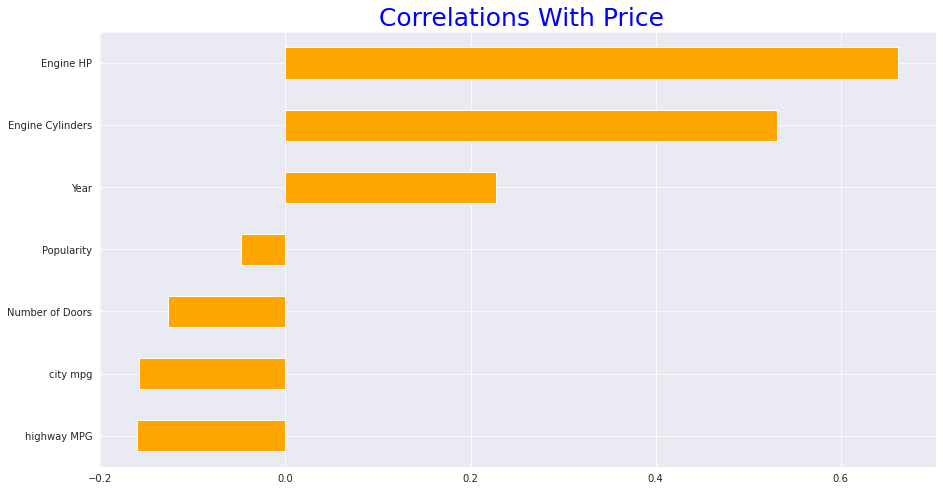

In [65]:
sns.set_style("darkgrid")
pd_df.corr()["MSRP"].drop('MSRP').sort_values().plot.barh(figsize=(15,8), color="orange")
plt.title(" Correlations With Price", {"color":"blue", "fontsize":25});

In [66]:
def replace(column,value):
    return when(column!= value,column).otherwise(lit(None))
data_df = data_df.withColumn("Market Category",replace(col("Market Category"),"N/A"))

In [67]:
data_df.select([count(when(isnan(c)| col(c).isNull(),c).alias(c)) for c in data_df.columns]).toPandas()

count(CASE WHEN (isnan(Make) OR (Make IS NULL)) THEN Make END AS Make)  \
0                                                  0                        

   count(CASE WHEN (isnan(Model) OR (Model IS NULL)) THEN Model END AS Model)  \
0                                                  0                            

   count(CASE WHEN (isnan(Year) OR (Year IS NULL)) THEN Year END AS Year)  \
0                                                  0                        

   count(CASE WHEN (isnan(Engine Fuel Type) OR (Engine Fuel Type IS NULL)) THEN Engine Fuel Type END AS `Engine Fuel Type`)  \
0                                                  3                                                                          

   count(CASE WHEN (isnan(Engine HP) OR (Engine HP IS NULL)) THEN Engine HP END AS `Engine HP`)  \
0                                                 69                                              

   count(CASE WHEN (isnan(Engine Cylinders) OR (Engine Cylinders IS NULL)) THEN Engine Cylinders END AS `Engine Cylinders`)  \
0                                                 30                                                                          

   count(CASE WHEN (isnan(Transmission Type) OR (Transmission Type IS NULL)) THEN Transmission Type END AS `Transmission Type`)  \
0                                                  0                                                                              

   count(CASE WHEN (isnan(Driven_Wheels) OR (Driven_Wheels IS NULL)) THEN Driven_Wheels END AS Driven_Wheels)  \
0                                                  0                                                            

   count(CASE WHEN (isnan(Number of Doors) OR (Number of Doors IS NULL)) THEN Number of Doors END AS `Number of Doors`)  \
0                                                  6                                                                      

   count(CASE WHEN (isnan(Market Category) OR (Market Category IS NULL)) THEN Market Category END AS `Market Category`)  \
0                                               3742                                                                      

   count(CASE WHEN (isnan(Vehicle Size) OR (Vehicle Size IS NULL)) THEN Vehicle Size END AS `Vehicle Size`)  \
0                                                  0                                                          

   count(CASE WHEN (isnan(Vehicle Style) OR (Vehicle Style IS NULL)) THEN Vehicle Style END AS `Vehicle Style`)  \
0                                                  0                                                              

   count(CASE WHEN (isnan(highway MPG) OR (highway MPG IS NULL)) THEN highway MPG END AS `highway MPG`)  \
0                                                  0                                                      

   count(CASE WHEN (isnan(city mpg) OR (city mpg IS NULL)) THEN city mpg END AS `city mpg`)  \
0                                                  0                                          

   count(CASE WHEN (isnan(Popularity) OR (Popularity IS NULL)) THEN Popularity END AS Popularity)  \
0                                                  0                                                

   count(CASE WHEN (isnan(MSRP) OR (MSRP IS NULL)) THEN MSRP END AS MSRP)  
0                                                  0

In [68]:
data_df = data_df.drop("Market Category")
data_df = data_df.na.drop()

In [69]:
data_df.show()

+----+----------+----+--------------------+---------+----------------+-----------------+-----------------+---------------+------------+-------------+-----------+--------+----------+-----+
|Make|     Model|Year|    Engine Fuel Type|Engine HP|Engine Cylinders|Transmission Type|    Driven_Wheels|Number of Doors|Vehicle Size|Vehicle Style|highway MPG|city mpg|Popularity| MSRP|
+----+----------+----+--------------------+---------+----------------+-----------------+-----------------+---------------+------------+-------------+-----------+--------+----------+-----+
| BMW|1 Series M|2011|premium unleaded ...|      335|               6|           MANUAL| rear wheel drive|              2|     Compact|        Coupe|         26|      19|      3916|46135|
| BMW|  1 Series|2011|premium unleaded ...|      300|               6|           MANUAL| rear wheel drive|              2|     Compact|  Convertible|         28|      19|      3916|40650|
| BMW|  1 Series|2011|premium unleaded ...|      300|       

In [70]:
print((data_df.count(),len(data_df.columns)))

(11812, 15)


# Take the important features and put them into feature list

In [71]:
features_list = ['Year','Engine HP','Engine Cylinders','Number of Doors','highway MPG','city mpg','Popularity']

In [72]:
assembler = VectorAssembler(inputCols = features_list,outputCol = 'Attributes')

In [73]:
regressor = RandomForestRegressor(featuresCol = 'Attributes',labelCol = 'MSRP')

# Create a pipeline with the vector assembler and random forest regressor

In [74]:
pipeline = Pipeline(stages=[assembler,regressor])

In [75]:
pipeline.write().overwrite().save('pipeline')

In [76]:
!ls

data.csv  pipeline  sample_data


In [77]:
pipelineModel = Pipeline.load('pipeline')
paramGrid = ParamGridBuilder().addGrid(regressor.numTrees,[100,500]).build()
crossval = CrossValidator(estimator = pipelineModel,estimatorParamMaps = paramGrid,
                         evaluator = RegressionEvaluator(labelCol = 'MSRP'),numFolds = 3)

# Split the data into training and testing using a random split of 75% and 25%.

In [78]:
train_data,test_data = data_df.randomSplit([0.75,0.25],seed = 123)

# Fit the model

In [79]:
cvModel = crossval.fit(train_data)

In [80]:
bestModel = cvModel.bestModel
for x in range(len(bestModel.stages)):
  print(bestModel.stages[x])

VectorAssembler_70513752d32b
RandomForestRegressionModel: uid=RandomForestRegressor_a64e01df6257, numTrees=500, numFeatures=7


In [81]:
pred = cvModel.transform(test_data)

In [82]:
pred.select('MSRP','prediction').show()

+-----+------------------+
| MSRP|        prediction|
+-----+------------------+
|28030|32106.759750121404|
|30550| 38447.34583279939|
|29350|28080.136007142522|
|27900|27430.651182126094|
|34890|27430.651182126094|
|32990|27430.651182126094|
| 2827| 4654.279040547375|
| 3000| 4654.279040547375|
| 3086| 4799.736014775544|
| 3130| 4799.736014775544|
| 3012|4670.6490859278165|
| 3622| 5916.326470009101|
|22300|24593.189092125718|
|19400|22600.102467295186|
| 2042|5360.4224262234275|
| 2181|5350.7173137878735|
| 2066| 5272.159226736561|
| 2144| 5148.148844611881|
|48840|40457.762886378434|
|49440| 40207.83994654782|
+-----+------------------+
only showing top 20 rows



In [83]:
eval = RegressionEvaluator(labelCol='MSRP')

# Results

In [84]:
rmse = eval.evaluate(pred)
print('RMSE : %.3f'%rmse)

RMSE : 34171.535


In [85]:
mse = eval.evaluate(pred,{eval.metricName:'mse'})
print('MSE : %.3f'%mse)

MSE : 1167693817.755


In [86]:
mae = eval.evaluate(pred,{eval.metricName:'mae'})
print('MAE : %.3f'%mae)

MAE : 9707.860


In [87]:
r2 = eval.evaluate(pred,{eval.metricName:'r2'})
print('R2 : %.3f'%r2)

R2 : 0.780


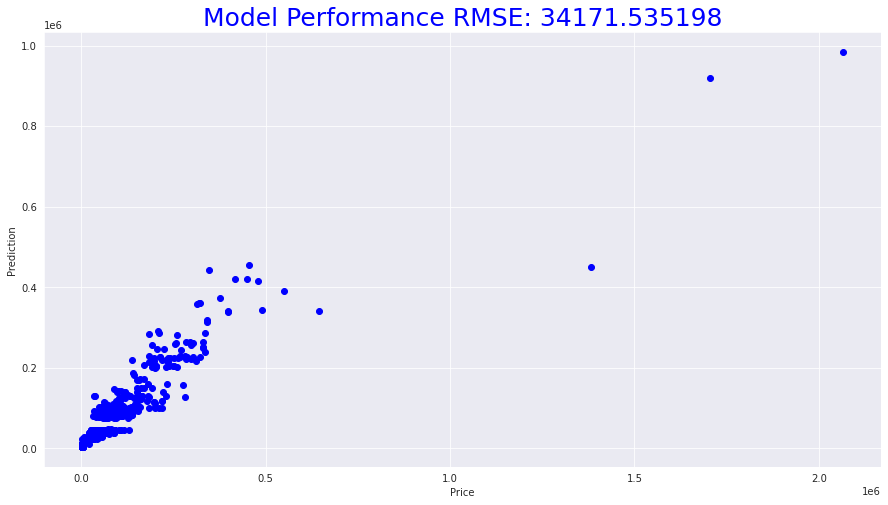

In [93]:

rfResult = pred.toPandas()
plt.figure(figsize=(15,8))
plt.plot(rfResult.MSRP, rfResult.prediction, 'bo')
plt.xlabel('Price')
plt.ylabel('Prediction')
plt.title("Model Performance RMSE: %f" % rmse, {"color":"blue", "fontsize":25})
plt.show()

Text(0.5, 1.0, 'Feature Importances')

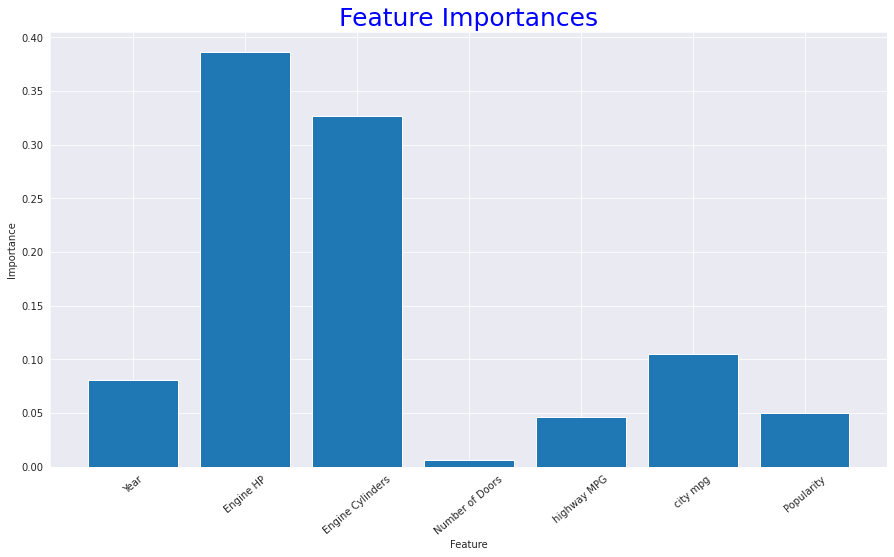

In [94]:
bestPipeline = cvModel.bestModel
bestModel = bestPipeline.stages[1]
importances = bestModel.featureImportances
x_values = list(range(len(importances)))
plt.figure(figsize=(15,8))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, features_list, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances', {"color":"blue", "fontsize":25})

In [95]:
print('numTrees - ', bestModel.getNumTrees)
print('maxDepth - ', bestModel.getOrDefault('maxDepth'))

numTrees -  500
maxDepth -  5
